In [1]:
# Import Libraries

import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
import datetime as dt
import pyfolio as pf
import pandas as pd
import numpy as np
import collections
import uuid                                 #in case for creating unique identifier
import matplotlib.pyplot as plt
import os
import math

/Users/siraphobpongkritsagorn/opt/anaconda3/envs/backtrader_35/lib/python3.5/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
# Define Utility Functions to detect acquisition activity within the lookback period

def is_stock_inactive_within_period(stock_data, start_date, end_date, consecutive_days=3):
    """
    Check if a stock has the same adjusted close price for a given number of consecutive days within a specified period.
    
    Parameters:
    stock_data (pd.DataFrame): DataFrame of stock prices with 'Date' and 'Adj Close'.
    start_date (datetime): Start date of the period.
    end_date (datetime): End date of the period.
    consecutive_days (int): Number of consecutive days to check for identical prices.
    
    Returns:
    bool: True if the stock is inactive within the period, False otherwise.
    """
    period_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]
    return (period_data['Adj Close'].rolling(window=consecutive_days).apply(lambda x: len(set(x)) == 1, raw=True).any())

In [3]:
# Feeding the Raw Data

# Paths to Raw Data
etf_tickers = ['XLY', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLB', 'XLP', 'XLU', 'XLRE', 'XLC']  # List of ETF tickers to consider
etf_data_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/Sector ETFs Data'
stock_data_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/Stocks Data/Raw Data YF format (handled 0 adj close) Sample for Testing'
benchmark_data_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/Benchmark Data'

# Defining the model number for referencing
model_number = "4_6"

# Specify the dates for data_feeds
start_date = dt.datetime(1999, 3, 1)  # Set a consistent start date for all data
end_date = dt.datetime(2021, 12, 31)  # Set a consistent end date for all data

# Initializing data_feeds
data_feeds = []

# Function to add specific ETF data feeds
def load_etf_feeds(tickers, path, start_date, end_date):
    for ticker in tickers:
        csv_file_path = os.path.join(path, "{}.csv".format(ticker))
        data = bt.feeds.YahooFinanceCSVData(dataname=csv_file_path, fromdate=start_date, todate=end_date)
        data_feeds.append(data)

def load_stock_feeds(path, start_date, end_date, lookback_period=252):
    for filename in os.listdir(path):
        if filename.endswith('.csv'):
            ticker = filename.split('.')[0]
            csv_file_path = os.path.join(path, "{}.csv".format(ticker))
            stock_df = pd.read_csv(csv_file_path, parse_dates=['Date'])
            
            # Check if stock is inactive within the lookback period
            lookback_start_date = end_date - pd.DateOffset(days=lookback_period)
            if not is_stock_inactive_within_period(stock_df, lookback_start_date, end_date):
                data = bt.feeds.YahooFinanceCSVData(dataname=csv_file_path, fromdate=start_date, todate=end_date)
                data_feeds.append(data)

# Function to load the market benchmark data
def load_benchmark_data(path, ticker, start_date, end_date):
    csv_file_path = os.path.join(path, "{}.csv".format(ticker))
    data = bt.feeds.YahooFinanceCSVData(dataname=csv_file_path, fromdate=start_date, todate=end_date)
    return data

# Load ETF data feeds
load_etf_feeds(etf_tickers, etf_data_path, start_date, end_date)

# Load Stocks data feeds
load_stock_feeds(stock_data_path, start_date, end_date)

# Load Benchmark data feed
benchmark_data = load_benchmark_data(benchmark_data_path, "^SP500TR", start_date, end_date)
data_feeds.append(benchmark_data)


In [4]:
# Special Cell: When dealing with only subsets of stocks for faster testing

# List to store tickers from files
stock_tickers = []

# Iterate over files in the directory
for filename in os.listdir(stock_data_path):
    if filename.endswith('.csv'):
        # Extract ticker from file name (assuming ticker is the file name without extension)
        ticker = os.path.splitext(filename)[0]
        stock_tickers.append(ticker)

print(stock_tickers)

['LBPQKWIKHR', 'KZBOUGKTTS', 'FAMSCYQMVD', 'KWGXPUYMNN', 'LEDYLZZPQU', 'HXWALUGZUC', 'IFLSGHENJE', 'LLQABGMYRY', 'SDGVPBNSGR', 'KXKTNEUVQZ', 'KYMJRCUORB', 'LDLWFBGKER', 'LFZOYRIYNK', 'LGBSHNLPSB', 'LBGJFWIIUJ', 'TTSZTNTGOA', 'LAWLETGSMX', 'LBBMJHXOEL', 'SFEVXKQEJC', 'LFZWVMHNWU', 'SONOALPTQK', 'KSLPKBUSMQ', 'PUVSJZKSSC', 'JJJOUYFLEQ', 'LDAWBBTEKR', 'YEFKESWODN', 'LAEDOIAPHK', 'UKBFZQYUFR', 'FHGASKLMNB', 'MTTFWLTDIM', 'KZNIWQFPKS', 'LAJJOLMAMN', 'MSOHUUPTLH', 'KWSXWZOBEC', 'RVGBXQUXUC', 'LFDCRPPIWT', 'UDJOUCWRRL', 'KWIVVGGUPL', 'ZJFFJZPVXX', 'KZOCYMSXXT', 'KZFPYTFQWH', 'KYCROCZTNO', 'LDBTFVGFKI', 'LADZNUQIOA', 'LEDFWPWEXK', 'LFUHJIQXXS', 'NFDMBWRWIE']


In [5]:
# Special SPX Daily Return Indicator

# Parameters for SPX Daily Return Indicator
rolling_window = 252  # Rolling window for mean and standard deviation calculation (can be adjusted)
sd_range = 5  # Standard deviation range for triggering rebalance (can be adjusted)

# Load the SPX data from the specified path
spx_file_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/Benchmark Data/^SP500TR.csv'
spx_df = pd.read_csv(spx_file_path, parse_dates=['Date'], index_col='Date')

# Calculate SPX daily returns
spx_df['Daily_Return'] = spx_df['Adj Close'].pct_change()

# Calculate rolling mean and standard deviation of SPX daily returns
spx_df['Rolling_Mean'] = spx_df['Daily_Return'].rolling(window=rolling_window).mean()
spx_df['Rolling_Std'] = spx_df['Daily_Return'].rolling(window=rolling_window).std()

# Calculate the upper and lower bounds for the indicator
spx_df['Upper_Bound'] = spx_df['Rolling_Mean'] + (sd_range * spx_df['Rolling_Std'])
spx_df['Lower_Bound'] = spx_df['Rolling_Mean'] - (sd_range * spx_df['Rolling_Std'])

# Determine if SPX daily return is outside the indicator bounds
spx_df['Outside_Bounds'] = (spx_df['Daily_Return'] > spx_df['Upper_Bound']) | (spx_df['Daily_Return'] < spx_df['Lower_Bound'])

# Create a list of dates when SPX daily return is outside bounds
outside_bounds_dates = spx_df[spx_df['Outside_Bounds']].index.tolist()

# Filter the DataFrame to include only the rows where daily return is outside bounds
outside_bounds_df = spx_df[spx_df['Outside_Bounds']]

# Create a new DataFrame with the desired columns
result_df = pd.DataFrame({
    'Outside_Bounds_Dates': outside_bounds_df.index,
    'Rolling_Mean_Return': outside_bounds_df['Rolling_Mean'],
    '1SD_Value': sd_range * outside_bounds_df['Rolling_Std'],
    'Upper_Bound_Value': outside_bounds_df['Upper_Bound'],
    'Lower_Bound_Value': outside_bounds_df['Lower_Bound'],
    'Daily_Return': outside_bounds_df['Daily_Return']
})

# Sort the columns in the desired order
result_df = result_df[['Outside_Bounds_Dates', 'Rolling_Mean_Return', '1SD_Value', 'Upper_Bound_Value', 'Lower_Bound_Value', 'Daily_Return']]

# Reset the index of the result DataFrame
result_df.reset_index(drop=True, inplace=True)

# Print the result DataFrame
result_df

,Outside_Bounds_Dates,Rolling_Mean_Return,1SD_Value,Upper_Bound_Value,Lower_Bound_Value,Daily_Return
0,1989-10-13,0.000932,0.040554,0.041487,-0.039622,-0.061165
1,1996-03-08,0.001137,0.029971,0.031109,-0.028834,-0.030822
2,1997-10-27,0.001039,0.052316,0.053355,-0.051277,-0.068651
3,1998-08-31,0.000385,0.061318,0.061702,-0.060933,-0.067997
4,2007-02-27,0.000420,0.032246,0.032666,-0.031826,-0.034640
5,2008-09-29,-0.001072,0.077625,0.076553,-0.078697,-0.087856
6,2008-10-13,-0.001493,0.094041,0.092548,-0.095534,0.115811
7,2008-10-28,-0.001637,0.108660,0.107023,-0.110298,0.107888
8,2011-08-04,0.000374,0.045845,0.046219,-0.045471,-0.047775
9,2011-08-08,0.000100,0.050409,0.050509,-0.050309,-0.066487



dates when Short MA is under Long MA:
DatetimeIndex(['1990-01-22', '1990-01-23', '1990-01-24', '1990-01-25',
               '1990-01-26', '1990-01-29', '1990-01-30', '1990-01-31',
               '1990-02-01', '1990-02-02',
               ...
               '2023-01-18', '2023-01-19', '2023-03-10', '2023-03-13',
               '2023-03-15', '2023-10-25', '2023-10-26', '2023-10-27',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', name='Date', length=1961, freq=None)


/Users/siraphobpongkritsagorn/opt/anaconda3/envs/backtrader_35/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


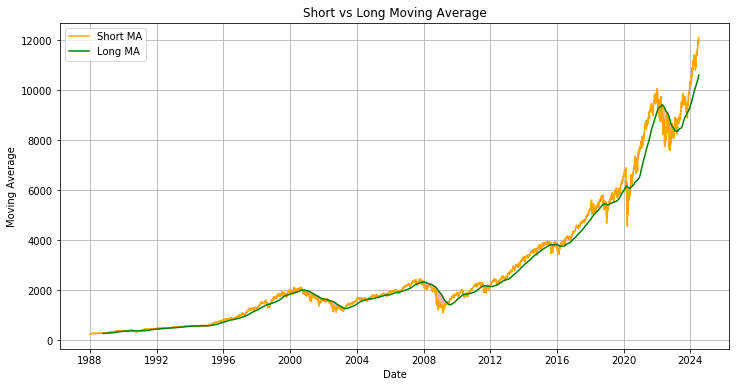

In [6]:
# SPX Trend Filter

# Define short and long moving average windows
short_ma_window = 1  # Default short MA window
long_ma_window = 200  # Default long MA window

# Calculate moving averages
spx_df['Short_MA'] = spx_df['Adj Close'].rolling(window=short_ma_window).mean()
spx_df['Long_MA'] = spx_df['Adj Close'].rolling(window=long_ma_window).mean()

# Identify dates when Short MA is under Long MA
short_ma_under_long_ma_dates = spx_df[spx_df['Short_MA'] < spx_df['Long_MA']].index

# Optionally, print some of these dates for verification
print("\ndates when Short MA is under Long MA:")
print(short_ma_under_long_ma_dates[:])

# Chart : Comparison of short and long Moving Averages with highlighting
plt.figure(figsize=(12, 6))
plt.plot(spx_df.index, spx_df['Short_MA'], label='Short MA', color='orange')
plt.plot(spx_df.index, spx_df['Long_MA'], label='Long MA', color='green')
plt.fill_between(spx_df.index, spx_df['Short_MA'], spx_df['Long_MA'], where=(spx_df['Short_MA'] < spx_df['Long_MA']), color='red', alpha=0.3)
plt.title('Short vs Long Moving Average')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Prepare all the libraries for S&P500 Universe and Sector Matching

"""
Prepare Sector ticker and name library
"""
# Sector library to map ETFs to GICS Sectors
sector_library_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/Sector Library.csv'
sector_library = pd.read_csv(sector_library_path)

# Create a dictionary to map ETF tickers to sector names
sector_mapping = dict(zip(sector_library['Ticker'], sector_library['Sector']))

"""
Identify the list of SP500 constituents over time
"""
sp500_constituents_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/20220402 S&P 500 Constituents Symbols.csv'
sp500_constituents = pd.read_csv(sp500_constituents_path, parse_dates=[0]) # Need to Parse the Date
# Extract only the date part from each datetime in sp500_constituents
sp500_constituents['0'] = sp500_constituents['0'].dt.date

"""
To match stock tickers with associated sector names
"""
stock_list_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/List of Tickers Updated with Sectors.csv'
stock_list = pd.read_csv(stock_list_path)
stock_list_dict = dict(zip(stock_list['Custom_Code'], stock_list['GICS Sector'].astype(str)))

# Display each uploaded Dataframe
print(sector_library)
print(sp500_constituents)
print(stock_list_dict)

   Ticker                  Sector
0     XLE                  Energy
1     XLU               Utilities
2     XLP        Consumer Staples
3    XLRE             Real Estate
4     XLF              Financials
5     XLV             Health Care
6     XLK  Information Technology
7     XLI             Industrials
8     XLY  Consumer Discretionary
9     XLB               Materials
10    XLC  Communication Services
               0           1           2           3           4           5  \
0     1990-01-01  OPJQMOEHNY  WXYGAWGGWE  GWVDDOPCIB  WODLCFUZAS  MKHPQRCVIH   
1     1990-01-02  OPJQMOEHNY  WXYGAWGGWE  GWVDDOPCIB  WODLCFUZAS  MKHPQRCVIH   
2     1990-01-03  OPJQMOEHNY  WXYGAWGGWE  GWVDDOPCIB  WODLCFUZAS  MKHPQRCVIH   
3     1990-01-04  OPJQMOEHNY  WXYGAWGGWE  GWVDDOPCIB  WODLCFUZAS  MKHPQRCVIH   
4     1990-01-05  OPJQMOEHNY  WXYGAWGGWE  GWVDDOPCIB  WODLCFUZAS  MKHPQRCVIH   
5     1990-01-08  OPJQMOEHNY  WXYGAWGGWE  GWVDDOPCIB  WODLCFUZAS  MKHPQRCVIH   
6     1990-01-09  OPJQMOEHNY  WX

/Users/siraphobpongkritsagorn/opt/anaconda3/envs/backtrader_35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Initial Cash and Commission Parameters

initial_cash = 100000  # Initial capital for backtesting
commission_pct = 0.000  # % Commission in decimals
slippage_pct = 0.00015  # % Slippage in decimals

In [9]:
class TestStrategy(bt.Strategy):
    """
    Section for Defining Relevant Parameters
    """
    params = (
        ("sharpe_period_short", 63),    # 3 months
        ("sharpe_period_medium", 126),  # 6 months
        ("sharpe_period_long", 252),    # 12 months
        ("rebalance_freq", 60),         # Rebalance every 3 months (approx 12 weeks)
        ("init_rebalance_count", 58),   # Start rebalancing from the first tradable date
        ("max_no_of_sectors", 4),       # Maximum number of assets to hold
        ("max_sector_weight", 1),       # Maximum weight for a single sector
        ("qualify_pct", 0.001),           # Top percentile of stocks in each sector allocation
        ("max_stock_weight", 1),        # Maximum weight for a single stock
        ("min_no_of_stocks", 3),        # Minimum number of stocks to select from each sector
        ("asset_short_sma_period", 1),  
        ("asset_long_sma_period", 200),  
        ("drawdown_threshold", 0.10),   # 10% drawdown threshold for triggering rebalance
    )
    
    """
    Section for Initializing the Strategy-Related Tools and Indicators
    """
    def __init__(self):
        # Initialize Portfolio Tracking and other attributes
        self.rebalance_count = self.params.init_rebalance_count
        self.current_alloc = {data: 0 for data in self.datas}
        self.target_alloc = {data: 0 for data in self.datas}
        self.d_with_len = []  # For subsets of the asset universe
        self.rebalance_date = None  # Initialize the rebalance_date attribute
        self.transaction_date = None  # Initialize the transaction_date attribute (t+1 rebalance date)
        self.inception = False  # Strategy Inception Signal

        # Initialize indicators for each asset
        self.short_smas = {data: bt.indicators.SimpleMovingAverage(data.close, period=self.params.asset_short_sma_period) for data in self.datas}
        self.long_smas = {data: bt.indicators.SimpleMovingAverage(data.close, period=self.params.asset_long_sma_period) for data in self.datas}
        self.sharpe_ratios = {data: self.calculate_avg_sharpe_ratio(data) for data in self.datas}

        # Mapping ETF tickers to sectors
        self.etf_to_sector = {row['Ticker']: row['Sector'] for index, row in sector_library.iterrows()}
        
        # Preparing a set for faster membership checking
        self.sp500_by_date = {date: set(sp500_constituents.iloc[index, 1:].dropna().values.tolist())
                              for index, date in enumerate(sp500_constituents.iloc[:, 0])}
        
        # Mapping stock tickers to sectors
        self.stock_to_sector = {row['Custom_Code']: row['GICS Sector'] for index, row in stock_list.iterrows()}

        # Calculate Sharpe ratios for the benchmark data
        self.benchmark_data = benchmark_data
        self.benchmark_sharpe = self.calculate_avg_sharpe_ratio(self.benchmark_data)

        # Initialize target weights for sector ETFs and benchmark
        self.sector_etf_target_weights = {ticker: 0 for ticker in etf_tickers}
        self.benchmark_target_weight = 0

    """
    Defining Momentum Indicator Calculations
    """
    # Helper method to calculate Sharpe Ratio for a single period
    def calculate_sharpe_ratio(self, daily_returns, period):
        rolling_mean = bt.indicators.SMA(daily_returns, period=period)
        rolling_std_dev = bt.indicators.StandardDeviation(daily_returns, period=period)

        # Add a small epsilon to avoid division by zero
        epsilon = 1e-8
        return rolling_mean / (rolling_std_dev + epsilon)  # Neglecting risk-free rate for simplicity

    # Helper method to calculate Avg. Sharpe Ratios for different periods 
    def calculate_avg_sharpe_ratio(self, data):
        daily_returns = data.close / data.close(-1) - 1
        return {
            'short': self.calculate_sharpe_ratio(daily_returns, self.params.sharpe_period_short),
            'medium': self.calculate_sharpe_ratio(daily_returns, self.params.sharpe_period_medium),
            'long': self.calculate_sharpe_ratio(daily_returns, self.params.sharpe_period_long),
            'average': (self.calculate_sharpe_ratio(daily_returns, self.params.sharpe_period_short) +
                        self.calculate_sharpe_ratio(daily_returns, self.params.sharpe_period_medium) +
                        self.calculate_sharpe_ratio(daily_returns, self.params.sharpe_period_long)) / 3
        }

    """
    Section for Helper Tools for Reporting and Debugging
    """
    # Helper tool to report the allocation status            
    def update_allocation(self):
        print("Current Allocation...")
        total_value = self.broker.get_value()
        
        for data in self.d_with_len:
            value = self.broker.get_value([data])
            weight = value / total_value if total_value > 0 else 0
            self.current_alloc[data] = weight

            if weight > 0:  # Only print if the weight is greater than zero
                print("%s: Value $%.2f, Weight %.2f%%" % (data._name, value, weight * 100))
                
        cash = self.broker.get_cash()
        print("Remaining Cash: $%.2f" % cash)

    # Helper tool to report the target allocation status
    def report_target_allocation(self):
        print("Target Allocation...")
        total_value = self.broker.get_value()
        for data, target_weight in self.target_alloc.items():
            target_value = target_weight * total_value
            print("%s: Target Value $%.2f, Target Weight %.2f%%" % (data._name, target_value, target_weight * 100))

    """
    Prenext: Section for Defining the conditions to start the backtest 
    (Important for multi-assets with different starting dates)
    """
    def prenext(self):
        # Populate d_with_len with assets that at least have enough data
        self.d_with_len = [d for d in self.datas if len(d) >= self.params.sharpe_period_long]
    
        # Only call next() if d_with_len is not empty
        if self.d_with_len:
            self.next()

    # Might be redundant. This is to call next once we have all assets ready. Might not be useful in this case
    def nextstart(self):
        # This is called exactly ONCE, when next is 1st called and defaults to call `next`
        #self.d_with_len = self.datas  # All data sets fulfill the guarantees now
        if self.d_with_len:
            self.next()
    
    """
    Next: Section for the Core Strategy's Logic
    """
    def next(self):
        # Identify current date
        current_date = self.datas[0].datetime.date(0)
        
        # Identify the Strategy's Inception (Useful since analyzer will use this signal to start)
        self.inception = True
        
        # For all days. Count towards the rebalance schedule
        self.rebalance_count += 1
        print("Next is called on %s" % self.datas[0].datetime.date(0))
        print("rebalance_count = %d" % self.rebalance_count)

        """
        For Rebalance Dates
        """
        # Check if it's normal rebalance schedule or outside_bound date
        if (
            self.rebalance_count % self.params.rebalance_freq == 0
            or current_date in outside_bounds_dates # SPX daily return Outliers
        ):
            # Store the rebalance date in an instance variable
            self.rebalance_date = self.datas[0].datetime.date(0)
            print("Rebalancing portfolio TARGET SETTING on date: %s" % self.rebalance_date)
            
            # Reset the target_alloc to make sure we are not left with any target weights calculated from prev rebalance
            for data in self.d_with_len:
                self.target_alloc[data] = 0

            """
            Operations on the Sector-allocation level: 
            Target weights will be used to multiply with individual stocks' target weight
            """
            # Create a subset of self.d_with_len that are part of etf_tickers only
            sector_etfs = [data for data in self.d_with_len if data._name in etf_tickers]
            
            # Rank Sectors based on the average Sharpe Ratio for ETFs only
            ranked_sectors = sorted(
                [(data, self.sharpe_ratios[data]['average']) for data in sector_etfs if data in self.sharpe_ratios], 
                key=lambda x: x[1][0] if x[1][0] is not None else float('-inf'), 
                reverse=True)[:self.params.max_no_of_sectors]
            
            # Filter ranked sectors by Sharpe Ratio trend condition (average Sharpe Ratio must be positive)
            qualified_sectors = [(data, sharpe_ratio) for data, sharpe_ratio in ranked_sectors if sharpe_ratio > 0]
            
            # Calculate the sum of Average Sharpe Ratios of the qualified sectors
            sector_total_sharpe = sum(sharpe_ratio for data, sharpe_ratio in qualified_sectors)
            
            # Initialize a dictionary to store sector allocations
            sector_name_and_allocations = {}
            
            # Calculate the target allocation for each qualified sector
            for data, sharpe_ratio in qualified_sectors:
                num_qualified_sectors = len(qualified_sectors)

                # Calculate target allocation based on the sector's proportion of the total Sharpe Ratio
                target_sector_alloc = (sharpe_ratio / sector_total_sharpe) * (num_qualified_sectors / self.params.max_no_of_sectors)

                # Store the sector name and its corresponding allocation in the dictionary
                sector_name = sector_mapping.get(data._name, 'Unknown')
                sector_name_and_allocations[sector_name] = target_sector_alloc
            
            # Output will be a dict of { sector_name: Allocation }
            print("Sector Allocations:", sector_name_and_allocations) # It's a dictionary of (sector ticker : weight)
            
            """
            Operations on the individual-stock-allocation level
            """
            # Generate a list of stocks with available data in case we use a subset of stocks to test
            available_stocks = stock_tickers
            
            # Report the number of stocks in the universe (SP500 constituents by date)
            active_universe = list(set(self.sp500_by_date.get(current_date, set())))
            print("There are {} SP500 stocks on {}".format(len(active_universe), current_date))
            
            # Filter only available stocks that match the S&P 500 constituents on the rebalance date and are available
            active_stocks = list(set(self.sp500_by_date.get(current_date, set())) & set(available_stocks))
            print("Active Stocks on {}: {}".format(current_date, len(active_stocks)))
            
            # Initialize a dictionary to store stock allocations
            stock_name_and_weights = {}
            
            # Filter stock_list_dict to include only available stocks in qualifying sectors
            # Exclude inactive stocks based on the lookback period
            lookback_start_date = current_date - pd.DateOffset(days=self.params.sharpe_period_long)
            filtered_stock_list_dict = {
                ticker: sector 
                for ticker, sector in stock_list_dict.items() 
                if sector in sector_name_and_allocations
                and ticker in active_stocks
                and not is_stock_inactive_within_period(pd.read_csv(os.path.join(stock_data_path, "{}.csv".format(ticker)), parse_dates=['Date']), lookback_start_date, current_date)
            }
        
            # Initialize sector ETF and benchmark target weights to 0 before aggregation
            self.sector_etf_target_weights = {data: 0 for data in self.datas if data._name in etf_tickers}
            self.benchmark_target_weight = 0

            # Loop through each qualifying sector to get the list of stocks in the sector
            for sector_name, allocation in sector_name_and_allocations.items():
                # Make a List stocks to include only those in the current sector
                sector_stocks = [ticker for ticker, sector in filtered_stock_list_dict.items() if sector == sector_name]
                print("There are {} stocks in {}".format(len(sector_stocks), sector_name))

                # Calculate the number of stocks to select based on the qualify_pct parameter
                num_stocks_to_select = math.ceil(len(sector_stocks) * self.params.qualify_pct)
                print("{} stocks from {} are in the top {}".format(num_stocks_to_select, len(sector_stocks), self.params.qualify_pct))
                
                # Ensure at least the minimum number of stocks are selected
                num_stocks_to_select = max(num_stocks_to_select, self.params.min_no_of_stocks)
                
                """
                Ranking part: Note that we must operate on data_feeds
                """
                # Call the Data_feeds from the list of sector_stocks
                sector_stocks_data = [data for data in self.d_with_len if data._name in sector_stocks]
                
                # Rank Stocks based on the average Sharpe Ratio for stocks. Add a condition to exclude unusual values of sharpe from unusual prices (e.g. being acquired)
                ranked_sector_stocks = sorted(
                    [(data, self.sharpe_ratios[data]['average']) for data in sector_stocks_data if data in self.sharpe_ratios and self.sharpe_ratios[data]['average'] <= 10000],
                    key=lambda x: x[1][0] if x[1][0] is not None else float('-inf'),
                    reverse=True
                )[:num_stocks_to_select]

                """
                Key Ranking Mechanism : Note that now we operate on data_feeds
                """
                # Filter ranked stocks by Sharpe Ratio trend condition (average Sharpe Ratio must be positive)
                qualified_sector_stocks = [(data, sharpe_ratio) for data, sharpe_ratio in ranked_sector_stocks if sharpe_ratio > 0]
                print("Number of qualifying stocks in {} is {}".format(sector_name, len(qualified_sector_stocks)))

                # Calculate the sum of Average Sharpe Ratios of the qualified stocks
                sector_stock_total_sharpe = sum(sharpe_ratio for data, sharpe_ratio in qualified_sector_stocks)

                """
                Weighting Allocation Calculation
                """
                # Calculate the target allocation for each qualified stock
                for data, sharpe_ratio in qualified_sector_stocks:
                    num_qualified_sector_stocks = len(qualified_sector_stocks)

                    # Calculate target allocation proportion of the total Sharpe Ratio
                    target_weight = (sharpe_ratio / sector_stock_total_sharpe) * (num_qualified_sector_stocks / len(ranked_sector_stocks)) * allocation * 0.99

                    # Determine if the stock's Sharpe ratio is lower than its sector ETF or the market benchmark
                    sector_etf_ticker = None
                    sector_etf_data = None
                    for etf, sector in self.etf_to_sector.items():
                        if sector == sector_name:
                            sector_etf_ticker = etf  # we get the ticker like XLK
                            sector_etf_data = next((etf_data for etf_data in sector_etfs if etf_data._name == sector_etf_ticker), None)
                            print("Sector ETF Ticker for sector {}: {}".format(sector_name, sector_etf_ticker))
                            break

                    sector_etf_sharpe = self.sharpe_ratios[sector_etf_data]['average'] if sector_etf_data else 0

                    max_sharpe = max(sharpe_ratio, sector_etf_sharpe, self.benchmark_sharpe['average'])

                    if max_sharpe == sector_etf_sharpe:
                        # Aggregate weight to the sector ETF
                        self.sector_etf_target_weights[sector_etf_data] += target_weight
                    elif max_sharpe == self.benchmark_sharpe['average']:
                        # Aggregate weight to the benchmark
                        self.benchmark_target_weight += target_weight
                    else:
                        # Assign weight to the stock itself
                        self.target_alloc[data] = min(target_weight, self.params.max_stock_weight)
                        print("{} target weight: {}".format(data._name, target_weight))
                        
                    # Store the ticker and its allocation in stock_name_and_weights 
                    """
                    It's stored in data_feed format
                    E.g. <AAPL Data Feed>: 0.25,  # Target allocation weight for AAPL
                    """
                    stock_name_and_weights[data] = target_weight

            # Print the aggregated target weights for sector ETFs and the benchmark
            # print("Sector ETF Target Weights:", self.sector_etf_target_weights)
            print("Benchmark Target Weight:", self.benchmark_target_weight)

            # Set target allocations for sector ETFs and benchmark
            for data in self.d_with_len:
                if data in self.sector_etf_target_weights:
                    print(len(sector_etfs))
                    print(data._name)
                    print("{} target weight : {}".format(data._name , self.sector_etf_target_weights[data]))
                    self.target_alloc[data] = self.sector_etf_target_weights[data]
                elif data._name == "^SP500TR":
                    self.target_alloc[data] = self.benchmark_target_weight

            """
            After assigning target stocks' weights, we need to assign the rest 0
            """
            # After calculating stock_allocations, assign 0 target weight to assets not in stock_name_and_weights
            for data in self.d_with_len:
                if data not in stock_name_and_weights and data not in self.sector_etf_target_weights and data._name != "^SP500TR":
                    self.target_alloc[data] = 0

            """
            Transactions Logic
            """
            # Selling Phase: Important to sell first.
            self.sell_alloc = {}
            for data in self.d_with_len:
                current_weight = self.current_alloc[data] # Default starts with 0 for current_alloc
                target_weight = self.target_alloc[data]
                
                # Modify the target_weight to incorporate half rebalance SPX daily return Outliers
                if current_date in outside_bounds_dates: # SPX daily return Outliers
                    target_weight = (current_weight + target_weight) / 2
                
                cut_weight = current_weight - target_weight
                
                adjusted_target_weight = current_weight - cut_weight

                if current_weight > target_weight:
                    self.sell_alloc[data] = adjusted_target_weight
                    self.order_target_percent(data, target=adjusted_target_weight, exectype=bt.Order.Market) # Execute at next Open (adj)
                    print("Selling %s: Target %.2f%%, Current %.2f%%" % (data._name, target_weight * 100, current_weight * 100))
                    
            # Buying Phase
            self.buy_alloc = {}
            for data in self.d_with_len:
                if data not in self.sell_alloc: # We exclude assets that were just sold
                    current_weight = self.current_alloc[data]
                    target_weight = self.target_alloc[data]
                    
                    # Modify the target_weight to incorporate half rebalance SPX daily return Outliers
                    if current_date in outside_bounds_dates: # SPX daily return Outliers
                        target_weight = (current_weight + target_weight) / 2
                            
                    additional_weight = target_weight - current_weight  # Intended additional weight
                    
                    # Apply trend SPX trendfilter
                    if current_date in short_ma_under_long_ma_dates: 
                        additional_weight = additional_weight * 0 # Stop/Reduce buying when SPX short MA is under long MA
                    
                    adjusted_target_weight = current_weight + additional_weight
                    
                    if adjusted_target_weight > 0:  # Only report for assets that we want to buy
                        self.order_target_percent(data, target=adjusted_target_weight, exectype=bt.Order.Market) # Execute at next Open (adj)
                        self.buy_alloc[data] = adjusted_target_weight
                        print("Buying %s: Target %.2f%%" % (data._name, adjusted_target_weight * 100))
                        
        # For Transactions Days (The days the actual transactions happen)
        # Important to also check rebalance_date is not none
        # We check to locate the date after rebalancing date
        if self.rebalance_date and self.datas[0].datetime.date(0) == self.rebalance_date + dt.timedelta(days=1):
            # Store the transaction date in an instance variable
            self.transaction_date = self.datas[0].datetime.date(0)
            print("Transactions EXECUTED on date: %s" % self.transaction_date)
            print("Post Transactions Allocation Below")
            # Update Current Allocation 
            self.update_allocation()


In [10]:
class PortfolioAnalyzer(bt.Analyzer):
    
    def __init__(self):
        self.portfolio_data = []
        self.previous_portfolio_value = None  # To store the portfolio value of the previous day for daily P/L calculation

    def next(self):
        # Check if the inception flag is True in the strategy
        if not self.strategy.inception:
            # If not, skip this iteration
            return
        
        current_portfolio_value = self.strategy.broker.getvalue()
        current_cash = self.strategy.broker.get_cash()
        current_equity_value = current_portfolio_value - current_cash

        # Calculate daily P/L and accumulated P/L
        daily_pl = current_portfolio_value - self.previous_portfolio_value if self.previous_portfolio_value else 0
        daily_pl_percent = (daily_pl / self.previous_portfolio_value) * 100 if self.previous_portfolio_value else 0
        accumulated_pl = current_portfolio_value - self.strategy.broker.startingcash
        accumulated_pl_percent = (accumulated_pl / self.strategy.broker.startingcash) * 100

        # Append the current portfolio state to the portfolio data list
        self.portfolio_data.append({
            'date': self.strategy.datetime.date(0),
            'equity_value': current_equity_value,
            'cash_value': current_cash,
            'portfolio_value': current_portfolio_value,
            'equity_percent': (current_equity_value / current_portfolio_value) * 100,
            'cash_percent': (current_cash / current_portfolio_value) * 100,
            'daily_pl': daily_pl,
            'daily_pl_percent': daily_pl_percent,
            'accumulated_pl': accumulated_pl,
            'accumulated_pl_percent': accumulated_pl_percent
        })

        # Update the previous portfolio value for the next calculation
        self.previous_portfolio_value = current_portfolio_value

    def get_analysis(self):
        # Return the recorded portfolio data
        return self.portfolio_data


In [11]:
class TransactionTracker(bt.Analyzer):
    
    def __init__(self):
        self.transactions = []
        #self.tradeids = {}  # Dictionary to keep track of trade IDs and related buy orders

    def notify_order(self, order):
        # Check if the inception flag is True before recording transactions
        # This ensures transactions are only tracked when the strategy starts actual trading
        if not self.strategy.inception:
            # If inception is not True, return without recording the transaction
            return

        if order.status in [order.Completed]:
            
            if order.isbuy():
                direction = 'BUY'
                # Generate a new unique trade ID for this buy order, for example, using a UUID
                #trade_id = str(uuid.uuid4())
                #self.tradeids[order.ref] = trade_id
                
            else:
                direction = 'SELL'
                # Retrieve the existing trade ID for this sell order based on the buy order's ref
                #trade_id = self.tradeids.get(order.ref, 'UNKNOWN')
                
            # Append transaction details to the transactions list
            # Only completed orders are considered, reflecting actual executed trades
            self.transactions.append({
                'date': self.strategy.datetime.date(0), # The date of the transaction
                'ticker': order.data._name,             # Ticker symbol of the traded asset
                'price': order.executed.price,          # Execution price of the order
                'size': order.executed.size,            # The size of the order (number of shares/contracts)
                'value': order.executed.value,          # The monetary value of the order
                'commission': order.executed.comm,      # Commission paid for the order
                'direction': direction,                 # The direction of the trade, 'BUY' or 'SELL'
                'total cost': order.executed.value + order.executed.comm  # Total cost including commission
                #'tradeid': trade_id,                    # Unique identifier for the buy-sell couple

            })

    def get_analysis(self):
        # Return the recorded transactions
        return self.transactions

In [12]:
# Setting up the engine and trigger the strategy to run


# Create a cerebro object
cerebro = bt.Cerebro()

# Assuming data_feeds is your list of data feeds
for data in data_feeds:
    cerebro.adddata(data)

# Add the strategy to Cerebro and pass the stop loss and recovery dates
cerebro.addstrategy(TestStrategy)

# Set initial cash
cerebro.broker.set_cash(initial_cash)

# Add the commission
cerebro.broker.setcommission(commission=commission_pct)

# Add slippage as a percentage of the order price
cerebro.broker.set_slippage_perc(slippage_pct, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)

# Add the portfolio tracker
cerebro.addanalyzer(PortfolioAnalyzer, _name='portfolio_data')

# Add the transaction tracker
cerebro.addanalyzer(TransactionTracker, _name='transaction_data')

# Add PyFolio analyzer
cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')

# Run the strategy
results = cerebro.run()

# Plot the result
#cerebro.plot()

# Construct the portfolio tracker
portfolio_data = results[0].analyzers.getbyname('portfolio_data').get_analysis()

# Construct the transaction tracker
transaction_data = results[0].analyzers.getbyname('transaction_data').get_analysis()

# Construct the PyFolio items
strat = results[0]
pyfolio_analyzer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

Next is called on 2000-02-25
rebalance_count = 59
Next is called on 2000-02-28
rebalance_count = 60
Rebalancing portfolio TARGET SETTING on date: 2000-02-28
Sector Allocations: {'Health Care': 0.01682265716439042, 'Information Technology': 0.4831773428356096}
There are 500 SP500 stocks on 2000-02-28
Active Stocks on 2000-02-28: 16
There are 2 stocks in Health Care
1 stocks from 2 are in the top 0.001
Number of qualifying stocks in Health Care is 0
There are 3 stocks in Information Technology
1 stocks from 3 are in the top 0.001
Number of qualifying stocks in Information Technology is 1
Sector ETF Ticker for sector Information Technology: XLK
Benchmark Target Weight: 0
9
XLY
XLY target weight : 0
9
XLE
XLE target weight : 0
9
XLF
XLF target weight : 0
9
XLV
XLV target weight : 0
9
XLI
XLI target weight : 0
9
XLK
XLK target weight : 0.4783455694072535
9
XLB
XLB target weight : 0
9
XLP
XLP target weight : 0
9
XLU
XLU target weight : 0
Next is called on 2000-02-29
rebalance_count = 61
Tran

/Users/siraphobpongkritsagorn/opt/anaconda3/envs/backtrader_35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  app.launch_new_instance()



rebalance_count = 88
Next is called on 2000-04-07
rebalance_count = 89
Next is called on 2000-04-10
rebalance_count = 90
Next is called on 2000-04-11
rebalance_count = 91
Next is called on 2000-04-12
rebalance_count = 92
Next is called on 2000-04-13
rebalance_count = 93
Next is called on 2000-04-14
rebalance_count = 94
Next is called on 2000-04-17
rebalance_count = 95
Next is called on 2000-04-18
rebalance_count = 96
Next is called on 2000-04-19
rebalance_count = 97
Next is called on 2000-04-20
rebalance_count = 98
Next is called on 2000-04-24
rebalance_count = 99
Next is called on 2000-04-25
rebalance_count = 100
Next is called on 2000-04-26
rebalance_count = 101
Next is called on 2000-04-27
rebalance_count = 102
Next is called on 2000-04-28
rebalance_count = 103
Next is called on 2000-05-01
rebalance_count = 104
Next is called on 2000-05-02
rebalance_count = 105
Next is called on 2000-05-03
rebalance_count = 106
Next is called on 2000-05-04
rebalance_count = 107
Next is called on 20

Next is called on 2000-11-01
rebalance_count = 233
Next is called on 2000-11-02
rebalance_count = 234
Next is called on 2000-11-03
rebalance_count = 235
Next is called on 2000-11-06
rebalance_count = 236
Next is called on 2000-11-07
rebalance_count = 237
Next is called on 2000-11-08
rebalance_count = 238
Next is called on 2000-11-09
rebalance_count = 239
Next is called on 2000-11-10
rebalance_count = 240
Rebalancing portfolio TARGET SETTING on date: 2000-11-10
Sector Allocations: {'Utilities': 0.46149790944014546, 'Consumer Staples': 0.3301001041796376, 'Energy': 0.08400612617749212, 'Financials': 0.12439586020272499}
There are 500 SP500 stocks on 2000-11-10
Active Stocks on 2000-11-10: 16
There are 1 stocks in Utilities
1 stocks from 1 are in the top 0.001
Number of qualifying stocks in Utilities is 0
There are 0 stocks in Consumer Staples
0 stocks from 0 are in the top 0.001
Number of qualifying stocks in Consumer Staples is 0
There are 1 stocks in Energy
1 stocks from 1 are in the t

There are 1 stocks in Utilities
1 stocks from 1 are in the top 0.001
Number of qualifying stocks in Utilities is 0
There are 1 stocks in Materials
1 stocks from 1 are in the top 0.001
Number of qualifying stocks in Materials is 1
Sector ETF Ticker for sector Materials: XLB
There are 1 stocks in Energy
1 stocks from 1 are in the top 0.001
Number of qualifying stocks in Energy is 0
There are 0 stocks in Consumer Discretionary
0 stocks from 0 are in the top 0.001
Number of qualifying stocks in Consumer Discretionary is 0
Benchmark Target Weight: 0
9
XLY
XLY target weight : 0
9
XLE
XLE target weight : 0
9
XLF
XLF target weight : 0
9
XLV
XLV target weight : 0
9
XLI
XLI target weight : 0
9
XLK
XLK target weight : 0
9
XLB
XLB target weight : 0.38846573217527014
9
XLP
XLP target weight : 0
9
XLU
XLU target weight : 0
Next is called on 2001-05-08
rebalance_count = 361
Transactions EXECUTED on date: 2001-05-08
Post Transactions Allocation Below
Current Allocation...
Remaining Cash: $96800.35
Nex

Next is called on 2001-11-16
rebalance_count = 492
Next is called on 2001-11-19
rebalance_count = 493
Next is called on 2001-11-20
rebalance_count = 494
Next is called on 2001-11-21
rebalance_count = 495
Next is called on 2001-11-23
rebalance_count = 496
Next is called on 2001-11-26
rebalance_count = 497
Next is called on 2001-11-27
rebalance_count = 498
Next is called on 2001-11-28
rebalance_count = 499
Next is called on 2001-11-29
rebalance_count = 500
Next is called on 2001-11-30
rebalance_count = 501
Next is called on 2001-12-03
rebalance_count = 502
Next is called on 2001-12-04
rebalance_count = 503
Next is called on 2001-12-05
rebalance_count = 504
Next is called on 2001-12-06
rebalance_count = 505
Next is called on 2001-12-07
rebalance_count = 506
Next is called on 2001-12-10
rebalance_count = 507
Next is called on 2001-12-11
rebalance_count = 508
Next is called on 2001-12-12
rebalance_count = 509
Next is called on 2001-12-13
rebalance_count = 510
Next is called on 2001-12-14
re

Next is called on 2002-07-01
rebalance_count = 646
Next is called on 2002-07-02
rebalance_count = 647
Next is called on 2002-07-03
rebalance_count = 648
Next is called on 2002-07-05
rebalance_count = 649
Next is called on 2002-07-08
rebalance_count = 650
Next is called on 2002-07-09
rebalance_count = 651
Next is called on 2002-07-10
rebalance_count = 652
Next is called on 2002-07-11
rebalance_count = 653
Next is called on 2002-07-12
rebalance_count = 654
Next is called on 2002-07-15
rebalance_count = 655
Next is called on 2002-07-16
rebalance_count = 656
Next is called on 2002-07-17
rebalance_count = 657
Next is called on 2002-07-18
rebalance_count = 658
Next is called on 2002-07-19
rebalance_count = 659
Next is called on 2002-07-22
rebalance_count = 660
Rebalancing portfolio TARGET SETTING on date: 2002-07-22
Sector Allocations: {}
There are 500 SP500 stocks on 2002-07-22
Active Stocks on 2002-07-22: 19
Benchmark Target Weight: 0
9
XLY
XLY target weight : 0
9
XLE
XLE target weight : 0

Next is called on 2003-02-24
rebalance_count = 809
Next is called on 2003-02-25
rebalance_count = 810
Next is called on 2003-02-26
rebalance_count = 811
Next is called on 2003-02-27
rebalance_count = 812
Next is called on 2003-02-28
rebalance_count = 813
Next is called on 2003-03-03
rebalance_count = 814
Next is called on 2003-03-04
rebalance_count = 815
Next is called on 2003-03-05
rebalance_count = 816
Next is called on 2003-03-06
rebalance_count = 817
Next is called on 2003-03-07
rebalance_count = 818
Next is called on 2003-03-10
rebalance_count = 819
Next is called on 2003-03-11
rebalance_count = 820
Next is called on 2003-03-12
rebalance_count = 821
Next is called on 2003-03-13
rebalance_count = 822
Next is called on 2003-03-14
rebalance_count = 823
Next is called on 2003-03-17
rebalance_count = 824
Next is called on 2003-03-18
rebalance_count = 825
Next is called on 2003-03-19
rebalance_count = 826
Next is called on 2003-03-20
rebalance_count = 827
Next is called on 2003-03-21
re

Next is called on 2003-08-05
rebalance_count = 922
Next is called on 2003-08-06
rebalance_count = 923
Next is called on 2003-08-07
rebalance_count = 924
Next is called on 2003-08-08
rebalance_count = 925
Next is called on 2003-08-11
rebalance_count = 926
Next is called on 2003-08-12
rebalance_count = 927
Next is called on 2003-08-13
rebalance_count = 928
Next is called on 2003-08-14
rebalance_count = 929
Next is called on 2003-08-15
rebalance_count = 930
Next is called on 2003-08-18
rebalance_count = 931
Next is called on 2003-08-19
rebalance_count = 932
Next is called on 2003-08-20
rebalance_count = 933
Next is called on 2003-08-21
rebalance_count = 934
Next is called on 2003-08-22
rebalance_count = 935
Next is called on 2003-08-25
rebalance_count = 936
Next is called on 2003-08-26
rebalance_count = 937
Next is called on 2003-08-27
rebalance_count = 938
Next is called on 2003-08-28
rebalance_count = 939
Next is called on 2003-08-29
rebalance_count = 940
Next is called on 2003-09-02
re

Next is called on 2004-03-05
rebalance_count = 1069
Next is called on 2004-03-08
rebalance_count = 1070
Next is called on 2004-03-09
rebalance_count = 1071
Next is called on 2004-03-10
rebalance_count = 1072
Next is called on 2004-03-11
rebalance_count = 1073
Next is called on 2004-03-12
rebalance_count = 1074
Next is called on 2004-03-15
rebalance_count = 1075
Next is called on 2004-03-16
rebalance_count = 1076
Next is called on 2004-03-17
rebalance_count = 1077
Next is called on 2004-03-18
rebalance_count = 1078
Next is called on 2004-03-19
rebalance_count = 1079
Next is called on 2004-03-22
rebalance_count = 1080
Rebalancing portfolio TARGET SETTING on date: 2004-03-22
Sector Allocations: {'Utilities': 0.27568979960217116, 'Consumer Staples': 0.20436087918658433, 'Energy': 0.28265641473884584, 'Financials': 0.23729290647239876}
There are 500 SP500 stocks on 2004-03-22
Active Stocks on 2004-03-22: 19
There are 1 stocks in Utilities
1 stocks from 1 are in the top 0.001
Number of quali

Next is called on 2004-08-18
rebalance_count = 1183
Next is called on 2004-08-19
rebalance_count = 1184
Next is called on 2004-08-20
rebalance_count = 1185
Next is called on 2004-08-23
rebalance_count = 1186
Next is called on 2004-08-24
rebalance_count = 1187
Next is called on 2004-08-25
rebalance_count = 1188
Next is called on 2004-08-26
rebalance_count = 1189
Next is called on 2004-08-27
rebalance_count = 1190
Next is called on 2004-08-30
rebalance_count = 1191
Next is called on 2004-08-31
rebalance_count = 1192
Next is called on 2004-09-01
rebalance_count = 1193
Next is called on 2004-09-02
rebalance_count = 1194
Next is called on 2004-09-03
rebalance_count = 1195
Next is called on 2004-09-07
rebalance_count = 1196
Next is called on 2004-09-08
rebalance_count = 1197
Next is called on 2004-09-09
rebalance_count = 1198
Next is called on 2004-09-10
rebalance_count = 1199
Next is called on 2004-09-13
rebalance_count = 1200
Rebalancing portfolio TARGET SETTING on date: 2004-09-13
Sector 

Next is called on 2005-03-02
rebalance_count = 1318
Next is called on 2005-03-03
rebalance_count = 1319
Next is called on 2005-03-04
rebalance_count = 1320
Rebalancing portfolio TARGET SETTING on date: 2005-03-04
Sector Allocations: {'Utilities': 0.2947009251846891, 'Materials': 0.20677324501335126, 'Industrials': 0.13669355490754248, 'Energy': 0.36183227489441716}
There are 500 SP500 stocks on 2005-03-04
Active Stocks on 2005-03-04: 19
There are 1 stocks in Utilities
1 stocks from 1 are in the top 0.001
Number of qualifying stocks in Utilities is 0
There are 1 stocks in Materials
1 stocks from 1 are in the top 0.001
Number of qualifying stocks in Materials is 0
There are 8 stocks in Industrials
1 stocks from 8 are in the top 0.001
Number of qualifying stocks in Industrials is 3
Sector ETF Ticker for sector Industrials: XLI
Sector ETF Ticker for sector Industrials: XLI
Sector ETF Ticker for sector Industrials: XLI
There are 1 stocks in Energy
1 stocks from 1 are in the top 0.001
Number

Next is called on 2005-08-26
rebalance_count = 1442
Next is called on 2005-08-29
rebalance_count = 1443
Next is called on 2005-08-30
rebalance_count = 1444
Next is called on 2005-08-31
rebalance_count = 1445
Next is called on 2005-09-01
rebalance_count = 1446
Next is called on 2005-09-02
rebalance_count = 1447
Next is called on 2005-09-06
rebalance_count = 1448
Next is called on 2005-09-07
rebalance_count = 1449
Next is called on 2005-09-08
rebalance_count = 1450
Next is called on 2005-09-09
rebalance_count = 1451
Next is called on 2005-09-12
rebalance_count = 1452
Next is called on 2005-09-13
rebalance_count = 1453
Next is called on 2005-09-14
rebalance_count = 1454
Next is called on 2005-09-15
rebalance_count = 1455
Next is called on 2005-09-16
rebalance_count = 1456
Next is called on 2005-09-19
rebalance_count = 1457
Next is called on 2005-09-20
rebalance_count = 1458
Next is called on 2005-09-21
rebalance_count = 1459
Next is called on 2005-09-22
rebalance_count = 1460
Next is call

Next is called on 2006-04-19
rebalance_count = 1603
Next is called on 2006-04-20
rebalance_count = 1604
Next is called on 2006-04-21
rebalance_count = 1605
Next is called on 2006-04-24
rebalance_count = 1606
Next is called on 2006-04-25
rebalance_count = 1607
Next is called on 2006-04-26
rebalance_count = 1608
Next is called on 2006-04-27
rebalance_count = 1609
Next is called on 2006-04-28
rebalance_count = 1610
Next is called on 2006-05-01
rebalance_count = 1611
Next is called on 2006-05-02
rebalance_count = 1612
Next is called on 2006-05-03
rebalance_count = 1613
Next is called on 2006-05-04
rebalance_count = 1614
Next is called on 2006-05-05
rebalance_count = 1615
Next is called on 2006-05-08
rebalance_count = 1616
Next is called on 2006-05-09
rebalance_count = 1617
Next is called on 2006-05-10
rebalance_count = 1618
Next is called on 2006-05-11
rebalance_count = 1619
Next is called on 2006-05-12
rebalance_count = 1620
Rebalancing portfolio TARGET SETTING on date: 2006-05-12
Sector 

Next is called on 2006-09-18
rebalance_count = 1708
Next is called on 2006-09-19
rebalance_count = 1709
Next is called on 2006-09-20
rebalance_count = 1710
Next is called on 2006-09-21
rebalance_count = 1711
Next is called on 2006-09-22
rebalance_count = 1712
Next is called on 2006-09-25
rebalance_count = 1713
Next is called on 2006-09-26
rebalance_count = 1714
Next is called on 2006-09-27
rebalance_count = 1715
Next is called on 2006-09-28
rebalance_count = 1716
Next is called on 2006-09-29
rebalance_count = 1717
Next is called on 2006-10-02
rebalance_count = 1718
Next is called on 2006-10-03
rebalance_count = 1719
Next is called on 2006-10-04
rebalance_count = 1720
Next is called on 2006-10-05
rebalance_count = 1721
Next is called on 2006-10-06
rebalance_count = 1722
Next is called on 2006-10-09
rebalance_count = 1723
Next is called on 2006-10-10
rebalance_count = 1724
Next is called on 2006-10-11
rebalance_count = 1725
Next is called on 2006-10-12
rebalance_count = 1726
Next is call

Next is called on 2007-03-16
rebalance_count = 1831
Next is called on 2007-03-19
rebalance_count = 1832
Next is called on 2007-03-20
rebalance_count = 1833
Next is called on 2007-03-21
rebalance_count = 1834
Next is called on 2007-03-22
rebalance_count = 1835
Next is called on 2007-03-23
rebalance_count = 1836
Next is called on 2007-03-26
rebalance_count = 1837
Next is called on 2007-03-27
rebalance_count = 1838
Next is called on 2007-03-28
rebalance_count = 1839
Next is called on 2007-03-29
rebalance_count = 1840
Next is called on 2007-03-30
rebalance_count = 1841
Next is called on 2007-04-02
rebalance_count = 1842
Next is called on 2007-04-03
rebalance_count = 1843
Next is called on 2007-04-04
rebalance_count = 1844
Next is called on 2007-04-05
rebalance_count = 1845
Next is called on 2007-04-09
rebalance_count = 1846
Next is called on 2007-04-10
rebalance_count = 1847
Next is called on 2007-04-11
rebalance_count = 1848
Next is called on 2007-04-12
rebalance_count = 1849
Next is call

Next is called on 2007-08-06
rebalance_count = 1929
Next is called on 2007-08-07
rebalance_count = 1930
Next is called on 2007-08-08
rebalance_count = 1931
Next is called on 2007-08-09
rebalance_count = 1932
Next is called on 2007-08-10
rebalance_count = 1933
Next is called on 2007-08-13
rebalance_count = 1934
Next is called on 2007-08-14
rebalance_count = 1935
Next is called on 2007-08-15
rebalance_count = 1936
Next is called on 2007-08-16
rebalance_count = 1937
Next is called on 2007-08-17
rebalance_count = 1938
Next is called on 2007-08-20
rebalance_count = 1939
Next is called on 2007-08-21
rebalance_count = 1940
Next is called on 2007-08-22
rebalance_count = 1941
Next is called on 2007-08-23
rebalance_count = 1942
Next is called on 2007-08-24
rebalance_count = 1943
Next is called on 2007-08-27
rebalance_count = 1944
Next is called on 2007-08-28
rebalance_count = 1945
Next is called on 2007-08-29
rebalance_count = 1946
Next is called on 2007-08-30
rebalance_count = 1947
Next is call

Next is called on 2008-02-21
rebalance_count = 2066
Next is called on 2008-02-22
rebalance_count = 2067
Next is called on 2008-02-25
rebalance_count = 2068
Next is called on 2008-02-26
rebalance_count = 2069
Next is called on 2008-02-27
rebalance_count = 2070
Next is called on 2008-02-28
rebalance_count = 2071
Next is called on 2008-02-29
rebalance_count = 2072
Next is called on 2008-03-03
rebalance_count = 2073
Next is called on 2008-03-04
rebalance_count = 2074
Next is called on 2008-03-05
rebalance_count = 2075
Next is called on 2008-03-06
rebalance_count = 2076
Next is called on 2008-03-07
rebalance_count = 2077
Next is called on 2008-03-10
rebalance_count = 2078
Next is called on 2008-03-11
rebalance_count = 2079
Next is called on 2008-03-12
rebalance_count = 2080
Next is called on 2008-03-13
rebalance_count = 2081
Next is called on 2008-03-14
rebalance_count = 2082
Next is called on 2008-03-17
rebalance_count = 2083
Next is called on 2008-03-18
rebalance_count = 2084
Next is call

Next is called on 2008-08-06
rebalance_count = 2182
Next is called on 2008-08-07
rebalance_count = 2183
Next is called on 2008-08-08
rebalance_count = 2184
Next is called on 2008-08-11
rebalance_count = 2185
Next is called on 2008-08-12
rebalance_count = 2186
Next is called on 2008-08-13
rebalance_count = 2187
Next is called on 2008-08-14
rebalance_count = 2188
Next is called on 2008-08-15
rebalance_count = 2189
Next is called on 2008-08-18
rebalance_count = 2190
Next is called on 2008-08-19
rebalance_count = 2191
Next is called on 2008-08-20
rebalance_count = 2192
Next is called on 2008-08-21
rebalance_count = 2193
Next is called on 2008-08-22
rebalance_count = 2194
Next is called on 2008-08-25
rebalance_count = 2195
Next is called on 2008-08-26
rebalance_count = 2196
Next is called on 2008-08-27
rebalance_count = 2197
Next is called on 2008-08-28
rebalance_count = 2198
Next is called on 2008-08-29
rebalance_count = 2199
Next is called on 2008-09-02
rebalance_count = 2200
Next is call

Next is called on 2009-02-23
rebalance_count = 2319
Next is called on 2009-02-24
rebalance_count = 2320
Next is called on 2009-02-25
rebalance_count = 2321
Next is called on 2009-02-26
rebalance_count = 2322
Next is called on 2009-02-27
rebalance_count = 2323
Next is called on 2009-03-02
rebalance_count = 2324
Next is called on 2009-03-03
rebalance_count = 2325
Next is called on 2009-03-04
rebalance_count = 2326
Next is called on 2009-03-05
rebalance_count = 2327
Next is called on 2009-03-06
rebalance_count = 2328
Next is called on 2009-03-09
rebalance_count = 2329
Next is called on 2009-03-10
rebalance_count = 2330
Next is called on 2009-03-11
rebalance_count = 2331
Next is called on 2009-03-12
rebalance_count = 2332
Next is called on 2009-03-13
rebalance_count = 2333
Next is called on 2009-03-16
rebalance_count = 2334
Next is called on 2009-03-17
rebalance_count = 2335
Next is called on 2009-03-18
rebalance_count = 2336
Next is called on 2009-03-19
rebalance_count = 2337
Next is call

Next is called on 2009-08-27
rebalance_count = 2449
Next is called on 2009-08-28
rebalance_count = 2450
Next is called on 2009-08-31
rebalance_count = 2451
Next is called on 2009-09-01
rebalance_count = 2452
Next is called on 2009-09-02
rebalance_count = 2453
Next is called on 2009-09-03
rebalance_count = 2454
Next is called on 2009-09-04
rebalance_count = 2455
Next is called on 2009-09-08
rebalance_count = 2456
Next is called on 2009-09-09
rebalance_count = 2457
Next is called on 2009-09-10
rebalance_count = 2458
Next is called on 2009-09-11
rebalance_count = 2459
Next is called on 2009-09-14
rebalance_count = 2460
Rebalancing portfolio TARGET SETTING on date: 2009-09-14
Sector Allocations: {'Health Care': 0.282223406941993, 'Consumer Staples': 0.2286292582908288, 'Information Technology': 0.25291256605033785, 'Consumer Discretionary': 0.23623476871684024}
There are 500 SP500 stocks on 2009-09-14
Active Stocks on 2009-09-14: 22
There are 3 stocks in Health Care
1 stocks from 3 are in 

Next is called on 2010-02-08
rebalance_count = 2561
Next is called on 2010-02-09
rebalance_count = 2562
Next is called on 2010-02-10
rebalance_count = 2563
Next is called on 2010-02-11
rebalance_count = 2564
Next is called on 2010-02-12
rebalance_count = 2565
Next is called on 2010-02-16
rebalance_count = 2566
Next is called on 2010-02-17
rebalance_count = 2567
Next is called on 2010-02-18
rebalance_count = 2568
Next is called on 2010-02-19
rebalance_count = 2569
Next is called on 2010-02-22
rebalance_count = 2570
Next is called on 2010-02-23
rebalance_count = 2571
Next is called on 2010-02-24
rebalance_count = 2572
Next is called on 2010-02-25
rebalance_count = 2573
Next is called on 2010-02-26
rebalance_count = 2574
Next is called on 2010-03-01
rebalance_count = 2575
Next is called on 2010-03-02
rebalance_count = 2576
Next is called on 2010-03-03
rebalance_count = 2577
Next is called on 2010-03-04
rebalance_count = 2578
Next is called on 2010-03-05
rebalance_count = 2579
Next is call

Next is called on 2010-06-07
rebalance_count = 2643
Next is called on 2010-06-08
rebalance_count = 2644
Next is called on 2010-06-09
rebalance_count = 2645
Next is called on 2010-06-10
rebalance_count = 2646
Next is called on 2010-06-11
rebalance_count = 2647
Next is called on 2010-06-14
rebalance_count = 2648
Next is called on 2010-06-15
rebalance_count = 2649
Next is called on 2010-06-16
rebalance_count = 2650
Next is called on 2010-06-17
rebalance_count = 2651
Next is called on 2010-06-18
rebalance_count = 2652
Next is called on 2010-06-21
rebalance_count = 2653
Next is called on 2010-06-22
rebalance_count = 2654
Next is called on 2010-06-23
rebalance_count = 2655
Next is called on 2010-06-24
rebalance_count = 2656
Next is called on 2010-06-25
rebalance_count = 2657
Next is called on 2010-06-28
rebalance_count = 2658
Next is called on 2010-06-29
rebalance_count = 2659
Next is called on 2010-06-30
rebalance_count = 2660
Next is called on 2010-07-01
rebalance_count = 2661
Next is call

Next is called on 2010-12-03
rebalance_count = 2769
Next is called on 2010-12-06
rebalance_count = 2770
Next is called on 2010-12-07
rebalance_count = 2771
Next is called on 2010-12-08
rebalance_count = 2772
Next is called on 2010-12-09
rebalance_count = 2773
Next is called on 2010-12-10
rebalance_count = 2774
Next is called on 2010-12-13
rebalance_count = 2775
Next is called on 2010-12-14
rebalance_count = 2776
Next is called on 2010-12-15
rebalance_count = 2777
Next is called on 2010-12-16
rebalance_count = 2778
Next is called on 2010-12-17
rebalance_count = 2779
Next is called on 2010-12-20
rebalance_count = 2780
Next is called on 2010-12-21
rebalance_count = 2781
Next is called on 2010-12-22
rebalance_count = 2782
Next is called on 2010-12-23
rebalance_count = 2783
Next is called on 2010-12-27
rebalance_count = 2784
Next is called on 2010-12-28
rebalance_count = 2785
Next is called on 2010-12-29
rebalance_count = 2786
Next is called on 2010-12-30
rebalance_count = 2787
Next is call

Next is called on 2011-06-28
rebalance_count = 2911
Next is called on 2011-06-29
rebalance_count = 2912
Next is called on 2011-06-30
rebalance_count = 2913
Next is called on 2011-07-01
rebalance_count = 2914
Next is called on 2011-07-05
rebalance_count = 2915
Next is called on 2011-07-06
rebalance_count = 2916
Next is called on 2011-07-07
rebalance_count = 2917
Next is called on 2011-07-08
rebalance_count = 2918
Next is called on 2011-07-11
rebalance_count = 2919
Next is called on 2011-07-12
rebalance_count = 2920
Next is called on 2011-07-13
rebalance_count = 2921
Next is called on 2011-07-14
rebalance_count = 2922
Next is called on 2011-07-15
rebalance_count = 2923
Next is called on 2011-07-18
rebalance_count = 2924
Next is called on 2011-07-19
rebalance_count = 2925
Next is called on 2011-07-20
rebalance_count = 2926
Next is called on 2011-07-21
rebalance_count = 2927
Next is called on 2011-07-22
rebalance_count = 2928
Next is called on 2011-07-25
rebalance_count = 2929
Next is call

Next is called on 2011-12-15
rebalance_count = 3030
Next is called on 2011-12-16
rebalance_count = 3031
Next is called on 2011-12-19
rebalance_count = 3032
Next is called on 2011-12-20
rebalance_count = 3033
Next is called on 2011-12-21
rebalance_count = 3034
Next is called on 2011-12-22
rebalance_count = 3035
Next is called on 2011-12-23
rebalance_count = 3036
Next is called on 2011-12-27
rebalance_count = 3037
Next is called on 2011-12-28
rebalance_count = 3038
Next is called on 2011-12-29
rebalance_count = 3039
Next is called on 2011-12-30
rebalance_count = 3040
Next is called on 2012-01-03
rebalance_count = 3041
Next is called on 2012-01-04
rebalance_count = 3042
Next is called on 2012-01-05
rebalance_count = 3043
Next is called on 2012-01-06
rebalance_count = 3044
Next is called on 2012-01-09
rebalance_count = 3045
Next is called on 2012-01-10
rebalance_count = 3046
Next is called on 2012-01-11
rebalance_count = 3047
Next is called on 2012-01-12
rebalance_count = 3048
Next is call

Next is called on 2012-05-18
rebalance_count = 3136
Next is called on 2012-05-21
rebalance_count = 3137
Next is called on 2012-05-22
rebalance_count = 3138
Next is called on 2012-05-23
rebalance_count = 3139
Next is called on 2012-05-24
rebalance_count = 3140
Next is called on 2012-05-25
rebalance_count = 3141
Next is called on 2012-05-29
rebalance_count = 3142
Next is called on 2012-05-30
rebalance_count = 3143
Next is called on 2012-05-31
rebalance_count = 3144
Next is called on 2012-06-01
rebalance_count = 3145
Next is called on 2012-06-04
rebalance_count = 3146
Next is called on 2012-06-05
rebalance_count = 3147
Next is called on 2012-06-06
rebalance_count = 3148
Next is called on 2012-06-07
rebalance_count = 3149
Next is called on 2012-06-08
rebalance_count = 3150
Next is called on 2012-06-11
rebalance_count = 3151
Next is called on 2012-06-12
rebalance_count = 3152
Next is called on 2012-06-13
rebalance_count = 3153
Next is called on 2012-06-14
rebalance_count = 3154
Next is call

Next is called on 2012-12-20
rebalance_count = 3284
Next is called on 2012-12-21
rebalance_count = 3285
Next is called on 2012-12-24
rebalance_count = 3286
Next is called on 2012-12-26
rebalance_count = 3287
Next is called on 2012-12-27
rebalance_count = 3288
Next is called on 2012-12-28
rebalance_count = 3289
Next is called on 2012-12-31
rebalance_count = 3290
Next is called on 2013-01-02
rebalance_count = 3291
Next is called on 2013-01-03
rebalance_count = 3292
Next is called on 2013-01-04
rebalance_count = 3293
Next is called on 2013-01-07
rebalance_count = 3294
Next is called on 2013-01-08
rebalance_count = 3295
Next is called on 2013-01-09
rebalance_count = 3296
Next is called on 2013-01-10
rebalance_count = 3297
Next is called on 2013-01-11
rebalance_count = 3298
Next is called on 2013-01-14
rebalance_count = 3299
Next is called on 2013-01-15
rebalance_count = 3300
Rebalancing portfolio TARGET SETTING on date: 2013-01-15
Sector Allocations: {'Health Care': 0.2262154390569475, 'In

Next is called on 2013-05-10
rebalance_count = 3380
Next is called on 2013-05-13
rebalance_count = 3381
Next is called on 2013-05-14
rebalance_count = 3382
Next is called on 2013-05-15
rebalance_count = 3383
Next is called on 2013-05-16
rebalance_count = 3384
Next is called on 2013-05-17
rebalance_count = 3385
Next is called on 2013-05-20
rebalance_count = 3386
Next is called on 2013-05-21
rebalance_count = 3387
Next is called on 2013-05-22
rebalance_count = 3388
Next is called on 2013-05-23
rebalance_count = 3389
Next is called on 2013-05-24
rebalance_count = 3390
Next is called on 2013-05-28
rebalance_count = 3391
Next is called on 2013-05-29
rebalance_count = 3392
Next is called on 2013-05-30
rebalance_count = 3393
Next is called on 2013-05-31
rebalance_count = 3394
Next is called on 2013-06-03
rebalance_count = 3395
Next is called on 2013-06-04
rebalance_count = 3396
Next is called on 2013-06-05
rebalance_count = 3397
Next is called on 2013-06-06
rebalance_count = 3398
Next is call

Next is called on 2013-11-25
rebalance_count = 3518
Next is called on 2013-11-26
rebalance_count = 3519
Next is called on 2013-11-27
rebalance_count = 3520
Next is called on 2013-11-29
rebalance_count = 3521
Next is called on 2013-12-02
rebalance_count = 3522
Next is called on 2013-12-03
rebalance_count = 3523
Next is called on 2013-12-04
rebalance_count = 3524
Next is called on 2013-12-05
rebalance_count = 3525
Next is called on 2013-12-06
rebalance_count = 3526
Next is called on 2013-12-09
rebalance_count = 3527
Next is called on 2013-12-10
rebalance_count = 3528
Next is called on 2013-12-11
rebalance_count = 3529
Next is called on 2013-12-12
rebalance_count = 3530
Next is called on 2013-12-13
rebalance_count = 3531
Next is called on 2013-12-16
rebalance_count = 3532
Next is called on 2013-12-17
rebalance_count = 3533
Next is called on 2013-12-18
rebalance_count = 3534
Next is called on 2013-12-19
rebalance_count = 3535
Next is called on 2013-12-20
rebalance_count = 3536
Next is call

Next is called on 2014-04-04
rebalance_count = 3607
Next is called on 2014-04-07
rebalance_count = 3608
Next is called on 2014-04-08
rebalance_count = 3609
Next is called on 2014-04-09
rebalance_count = 3610
Next is called on 2014-04-10
rebalance_count = 3611
Next is called on 2014-04-11
rebalance_count = 3612
Next is called on 2014-04-14
rebalance_count = 3613
Next is called on 2014-04-15
rebalance_count = 3614
Next is called on 2014-04-16
rebalance_count = 3615
Next is called on 2014-04-17
rebalance_count = 3616
Next is called on 2014-04-21
rebalance_count = 3617
Next is called on 2014-04-22
rebalance_count = 3618
Next is called on 2014-04-23
rebalance_count = 3619
Next is called on 2014-04-24
rebalance_count = 3620
Next is called on 2014-04-25
rebalance_count = 3621
Next is called on 2014-04-28
rebalance_count = 3622
Next is called on 2014-04-29
rebalance_count = 3623
Next is called on 2014-04-30
rebalance_count = 3624
Next is called on 2014-05-01
rebalance_count = 3625
Next is call

Next is called on 2014-10-07
rebalance_count = 3735
Next is called on 2014-10-08
rebalance_count = 3736
Next is called on 2014-10-09
rebalance_count = 3737
Next is called on 2014-10-10
rebalance_count = 3738
Next is called on 2014-10-13
rebalance_count = 3739
Next is called on 2014-10-14
rebalance_count = 3740
Next is called on 2014-10-15
rebalance_count = 3741
Next is called on 2014-10-16
rebalance_count = 3742
Next is called on 2014-10-17
rebalance_count = 3743
Next is called on 2014-10-20
rebalance_count = 3744
Next is called on 2014-10-21
rebalance_count = 3745
Next is called on 2014-10-22
rebalance_count = 3746
Next is called on 2014-10-23
rebalance_count = 3747
Next is called on 2014-10-24
rebalance_count = 3748
Next is called on 2014-10-27
rebalance_count = 3749
Next is called on 2014-10-28
rebalance_count = 3750
Next is called on 2014-10-29
rebalance_count = 3751
Next is called on 2014-10-30
rebalance_count = 3752
Next is called on 2014-10-31
rebalance_count = 3753
Next is call

Next is called on 2015-03-11
rebalance_count = 3841
Transactions EXECUTED on date: 2015-03-11
Post Transactions Allocation Below
Current Allocation...
XLV: Value $29497.70, Weight 14.60%
XLK: Value $16303.68, Weight 8.07%
RVGBXQUXUC: Value $23985.78, Weight 11.88%
Remaining Cash: $132191.04
Next is called on 2015-03-12
rebalance_count = 3842
Next is called on 2015-03-13
rebalance_count = 3843
Next is called on 2015-03-16
rebalance_count = 3844
Next is called on 2015-03-17
rebalance_count = 3845
Next is called on 2015-03-18
rebalance_count = 3846
Next is called on 2015-03-19
rebalance_count = 3847
Next is called on 2015-03-20
rebalance_count = 3848
Next is called on 2015-03-23
rebalance_count = 3849
Next is called on 2015-03-24
rebalance_count = 3850
Next is called on 2015-03-25
rebalance_count = 3851
Next is called on 2015-03-26
rebalance_count = 3852
Next is called on 2015-03-27
rebalance_count = 3853
Next is called on 2015-03-30
rebalance_count = 3854
Next is called on 2015-03-31
reb

Next is called on 2015-10-02
rebalance_count = 3984
Next is called on 2015-10-05
rebalance_count = 3985
Next is called on 2015-10-06
rebalance_count = 3986
Next is called on 2015-10-07
rebalance_count = 3987
Next is called on 2015-10-08
rebalance_count = 3988
Next is called on 2015-10-09
rebalance_count = 3989
Next is called on 2015-10-12
rebalance_count = 3990
Next is called on 2015-10-13
rebalance_count = 3991
Next is called on 2015-10-14
rebalance_count = 3992
Next is called on 2015-10-15
rebalance_count = 3993
Next is called on 2015-10-16
rebalance_count = 3994
Next is called on 2015-10-19
rebalance_count = 3995
Next is called on 2015-10-20
rebalance_count = 3996
Next is called on 2015-10-21
rebalance_count = 3997
Next is called on 2015-10-22
rebalance_count = 3998
Next is called on 2015-10-23
rebalance_count = 3999
Next is called on 2015-10-26
rebalance_count = 4000
Next is called on 2015-10-27
rebalance_count = 4001
Next is called on 2015-10-28
rebalance_count = 4002
Next is call

Next is called on 2016-03-21
rebalance_count = 4100
Next is called on 2016-03-22
rebalance_count = 4101
Next is called on 2016-03-23
rebalance_count = 4102
Next is called on 2016-03-24
rebalance_count = 4103
Next is called on 2016-03-28
rebalance_count = 4104
Next is called on 2016-03-29
rebalance_count = 4105
Next is called on 2016-03-30
rebalance_count = 4106
Next is called on 2016-03-31
rebalance_count = 4107
Next is called on 2016-04-01
rebalance_count = 4108
Next is called on 2016-04-04
rebalance_count = 4109
Next is called on 2016-04-05
rebalance_count = 4110
Next is called on 2016-04-06
rebalance_count = 4111
Next is called on 2016-04-07
rebalance_count = 4112
Next is called on 2016-04-08
rebalance_count = 4113
Next is called on 2016-04-11
rebalance_count = 4114
Next is called on 2016-04-12
rebalance_count = 4115
Next is called on 2016-04-13
rebalance_count = 4116
Next is called on 2016-04-14
rebalance_count = 4117
Next is called on 2016-04-15
rebalance_count = 4118
Next is call

Next is called on 2016-10-06
rebalance_count = 4239
Next is called on 2016-10-07
rebalance_count = 4240
Next is called on 2016-10-10
rebalance_count = 4241
Next is called on 2016-10-11
rebalance_count = 4242
Next is called on 2016-10-12
rebalance_count = 4243
Next is called on 2016-10-13
rebalance_count = 4244
Next is called on 2016-10-14
rebalance_count = 4245
Next is called on 2016-10-17
rebalance_count = 4246
Next is called on 2016-10-18
rebalance_count = 4247
Next is called on 2016-10-19
rebalance_count = 4248
Next is called on 2016-10-20
rebalance_count = 4249
Next is called on 2016-10-21
rebalance_count = 4250
Next is called on 2016-10-24
rebalance_count = 4251
Next is called on 2016-10-25
rebalance_count = 4252
Next is called on 2016-10-26
rebalance_count = 4253
Next is called on 2016-10-27
rebalance_count = 4254
Next is called on 2016-10-28
rebalance_count = 4255
Next is called on 2016-10-31
rebalance_count = 4256
Next is called on 2016-11-01
rebalance_count = 4257
Next is call

Next is called on 2017-04-06
rebalance_count = 4364
Next is called on 2017-04-07
rebalance_count = 4365
Next is called on 2017-04-10
rebalance_count = 4366
Next is called on 2017-04-11
rebalance_count = 4367
Next is called on 2017-04-12
rebalance_count = 4368
Next is called on 2017-04-13
rebalance_count = 4369
Next is called on 2017-04-17
rebalance_count = 4370
Next is called on 2017-04-18
rebalance_count = 4371
Next is called on 2017-04-19
rebalance_count = 4372
Next is called on 2017-04-20
rebalance_count = 4373
Next is called on 2017-04-21
rebalance_count = 4374
Next is called on 2017-04-24
rebalance_count = 4375
Next is called on 2017-04-25
rebalance_count = 4376
Next is called on 2017-04-26
rebalance_count = 4377
Next is called on 2017-04-27
rebalance_count = 4378
Next is called on 2017-04-28
rebalance_count = 4379
Next is called on 2017-05-01
rebalance_count = 4380
Rebalancing portfolio TARGET SETTING on date: 2017-05-01
Sector Allocations: {'Health Care': 0.2200152611730338, 'In

Next is called on 2017-09-26
rebalance_count = 4483
Next is called on 2017-09-27
rebalance_count = 4484
Next is called on 2017-09-28
rebalance_count = 4485
Next is called on 2017-09-29
rebalance_count = 4486
Next is called on 2017-10-02
rebalance_count = 4487
Next is called on 2017-10-03
rebalance_count = 4488
Next is called on 2017-10-04
rebalance_count = 4489
Next is called on 2017-10-05
rebalance_count = 4490
Next is called on 2017-10-06
rebalance_count = 4491
Next is called on 2017-10-09
rebalance_count = 4492
Next is called on 2017-10-10
rebalance_count = 4493
Next is called on 2017-10-11
rebalance_count = 4494
Next is called on 2017-10-12
rebalance_count = 4495
Next is called on 2017-10-13
rebalance_count = 4496
Next is called on 2017-10-16
rebalance_count = 4497
Next is called on 2017-10-17
rebalance_count = 4498
Next is called on 2017-10-18
rebalance_count = 4499
Next is called on 2017-10-19
rebalance_count = 4500
Rebalancing portfolio TARGET SETTING on date: 2017-10-19
Sector 

Next is called on 2018-03-20
rebalance_count = 4603
Next is called on 2018-03-21
rebalance_count = 4604
Next is called on 2018-03-22
rebalance_count = 4605
Next is called on 2018-03-23
rebalance_count = 4606
Next is called on 2018-03-26
rebalance_count = 4607
Next is called on 2018-03-27
rebalance_count = 4608
Next is called on 2018-03-28
rebalance_count = 4609
Next is called on 2018-03-29
rebalance_count = 4610
Next is called on 2018-04-02
rebalance_count = 4611
Next is called on 2018-04-03
rebalance_count = 4612
Next is called on 2018-04-04
rebalance_count = 4613
Next is called on 2018-04-05
rebalance_count = 4614
Next is called on 2018-04-06
rebalance_count = 4615
Next is called on 2018-04-09
rebalance_count = 4616
Next is called on 2018-04-10
rebalance_count = 4617
Next is called on 2018-04-11
rebalance_count = 4618
Next is called on 2018-04-12
rebalance_count = 4619
Next is called on 2018-04-13
rebalance_count = 4620
Rebalancing portfolio TARGET SETTING on date: 2018-04-13
Sector 

Next is called on 2018-07-13
rebalance_count = 4683
Next is called on 2018-07-16
rebalance_count = 4684
Next is called on 2018-07-17
rebalance_count = 4685
Next is called on 2018-07-18
rebalance_count = 4686
Next is called on 2018-07-19
rebalance_count = 4687
Next is called on 2018-07-20
rebalance_count = 4688
Next is called on 2018-07-23
rebalance_count = 4689
Next is called on 2018-07-24
rebalance_count = 4690
Next is called on 2018-07-25
rebalance_count = 4691
Next is called on 2018-07-26
rebalance_count = 4692
Next is called on 2018-07-27
rebalance_count = 4693
Next is called on 2018-07-30
rebalance_count = 4694
Next is called on 2018-07-31
rebalance_count = 4695
Next is called on 2018-08-01
rebalance_count = 4696
Next is called on 2018-08-02
rebalance_count = 4697
Next is called on 2018-08-03
rebalance_count = 4698
Next is called on 2018-08-06
rebalance_count = 4699
Next is called on 2018-08-07
rebalance_count = 4700
Next is called on 2018-08-08
rebalance_count = 4701
Next is call

Next is called on 2019-02-06
rebalance_count = 4825
Next is called on 2019-02-07
rebalance_count = 4826
Next is called on 2019-02-08
rebalance_count = 4827
Next is called on 2019-02-11
rebalance_count = 4828
Next is called on 2019-02-12
rebalance_count = 4829
Next is called on 2019-02-13
rebalance_count = 4830
Next is called on 2019-02-14
rebalance_count = 4831
Next is called on 2019-02-15
rebalance_count = 4832
Next is called on 2019-02-19
rebalance_count = 4833
Next is called on 2019-02-20
rebalance_count = 4834
Next is called on 2019-02-21
rebalance_count = 4835
Next is called on 2019-02-22
rebalance_count = 4836
Next is called on 2019-02-25
rebalance_count = 4837
Next is called on 2019-02-26
rebalance_count = 4838
Next is called on 2019-02-27
rebalance_count = 4839
Next is called on 2019-02-28
rebalance_count = 4840
Next is called on 2019-03-01
rebalance_count = 4841
Next is called on 2019-03-04
rebalance_count = 4842
Next is called on 2019-03-05
rebalance_count = 4843
Next is call

Next is called on 2019-07-11
rebalance_count = 4932
Next is called on 2019-07-12
rebalance_count = 4933
Next is called on 2019-07-15
rebalance_count = 4934
Next is called on 2019-07-16
rebalance_count = 4935
Next is called on 2019-07-17
rebalance_count = 4936
Next is called on 2019-07-18
rebalance_count = 4937
Next is called on 2019-07-19
rebalance_count = 4938
Next is called on 2019-07-22
rebalance_count = 4939
Next is called on 2019-07-23
rebalance_count = 4940
Next is called on 2019-07-24
rebalance_count = 4941
Next is called on 2019-07-25
rebalance_count = 4942
Next is called on 2019-07-26
rebalance_count = 4943
Next is called on 2019-07-29
rebalance_count = 4944
Next is called on 2019-07-30
rebalance_count = 4945
Next is called on 2019-07-31
rebalance_count = 4946
Next is called on 2019-08-01
rebalance_count = 4947
Next is called on 2019-08-02
rebalance_count = 4948
Next is called on 2019-08-05
rebalance_count = 4949
Next is called on 2019-08-06
rebalance_count = 4950
Next is call

Next is called on 2020-02-14
rebalance_count = 5083
Next is called on 2020-02-18
rebalance_count = 5084
Next is called on 2020-02-19
rebalance_count = 5085
Next is called on 2020-02-20
rebalance_count = 5086
Next is called on 2020-02-21
rebalance_count = 5087
Next is called on 2020-02-24
rebalance_count = 5088
Next is called on 2020-02-25
rebalance_count = 5089
Next is called on 2020-02-26
rebalance_count = 5090
Next is called on 2020-02-27
rebalance_count = 5091
Next is called on 2020-02-28
rebalance_count = 5092
Next is called on 2020-03-02
rebalance_count = 5093
Next is called on 2020-03-03
rebalance_count = 5094
Next is called on 2020-03-04
rebalance_count = 5095
Next is called on 2020-03-05
rebalance_count = 5096
Next is called on 2020-03-06
rebalance_count = 5097
Next is called on 2020-03-09
rebalance_count = 5098
Next is called on 2020-03-10
rebalance_count = 5099
Next is called on 2020-03-11
rebalance_count = 5100
Rebalancing portfolio TARGET SETTING on date: 2020-03-11
Sector 

Next is called on 2020-08-04
rebalance_count = 5201
Next is called on 2020-08-05
rebalance_count = 5202
Next is called on 2020-08-06
rebalance_count = 5203
Next is called on 2020-08-07
rebalance_count = 5204
Next is called on 2020-08-10
rebalance_count = 5205
Next is called on 2020-08-11
rebalance_count = 5206
Next is called on 2020-08-12
rebalance_count = 5207
Next is called on 2020-08-13
rebalance_count = 5208
Next is called on 2020-08-14
rebalance_count = 5209
Next is called on 2020-08-17
rebalance_count = 5210
Next is called on 2020-08-18
rebalance_count = 5211
Next is called on 2020-08-19
rebalance_count = 5212
Next is called on 2020-08-20
rebalance_count = 5213
Next is called on 2020-08-21
rebalance_count = 5214
Next is called on 2020-08-24
rebalance_count = 5215
Next is called on 2020-08-25
rebalance_count = 5216
Next is called on 2020-08-26
rebalance_count = 5217
Next is called on 2020-08-27
rebalance_count = 5218
Next is called on 2020-08-28
rebalance_count = 5219
Next is call

Next is called on 2020-12-02
rebalance_count = 5285
Next is called on 2020-12-03
rebalance_count = 5286
Next is called on 2020-12-04
rebalance_count = 5287
Next is called on 2020-12-07
rebalance_count = 5288
Next is called on 2020-12-08
rebalance_count = 5289
Next is called on 2020-12-09
rebalance_count = 5290
Next is called on 2020-12-10
rebalance_count = 5291
Next is called on 2020-12-11
rebalance_count = 5292
Next is called on 2020-12-14
rebalance_count = 5293
Next is called on 2020-12-15
rebalance_count = 5294
Next is called on 2020-12-16
rebalance_count = 5295
Next is called on 2020-12-17
rebalance_count = 5296
Next is called on 2020-12-18
rebalance_count = 5297
Next is called on 2020-12-21
rebalance_count = 5298
Next is called on 2020-12-22
rebalance_count = 5299
Next is called on 2020-12-23
rebalance_count = 5300
Next is called on 2020-12-24
rebalance_count = 5301
Next is called on 2020-12-28
rebalance_count = 5302
Next is called on 2020-12-29
rebalance_count = 5303
Next is call

There are 2 stocks in Materials
1 stocks from 2 are in the top 0.001
Number of qualifying stocks in Materials is 2
Sector ETF Ticker for sector Materials: XLB
JJJOUYFLEQ target weight: 0.1430799571125556
Sector ETF Ticker for sector Materials: XLB
There are 7 stocks in Industrials
1 stocks from 7 are in the top 0.001
Number of qualifying stocks in Industrials is 3
Sector ETF Ticker for sector Industrials: XLI
KZOCYMSXXT target weight: 0.09521375989102582
Sector ETF Ticker for sector Industrials: XLI
Sector ETF Ticker for sector Industrials: XLI
There are 3 stocks in Real Estate
1 stocks from 3 are in the top 0.001
Number of qualifying stocks in Real Estate is 3
Sector ETF Ticker for sector Real Estate: XLRE
YEFKESWODN target weight: 0.0928197984054818
Sector ETF Ticker for sector Real Estate: XLRE
Sector ETF Ticker for sector Real Estate: XLRE
There are 3 stocks in Financials
1 stocks from 3 are in the top 0.001
Number of qualifying stocks in Financials is 3
Sector ETF Ticker for secto

Next is called on 2021-10-11
rebalance_count = 5500
Next is called on 2021-10-12
rebalance_count = 5501
Next is called on 2021-10-13
rebalance_count = 5502
Next is called on 2021-10-14
rebalance_count = 5503
Next is called on 2021-10-15
rebalance_count = 5504
Next is called on 2021-10-18
rebalance_count = 5505
Next is called on 2021-10-19
rebalance_count = 5506
Next is called on 2021-10-20
rebalance_count = 5507
Next is called on 2021-10-21
rebalance_count = 5508
Next is called on 2021-10-22
rebalance_count = 5509
Next is called on 2021-10-25
rebalance_count = 5510
Next is called on 2021-10-26
rebalance_count = 5511
Next is called on 2021-10-27
rebalance_count = 5512
Next is called on 2021-10-28
rebalance_count = 5513
Next is called on 2021-10-29
rebalance_count = 5514
Next is called on 2021-11-01
rebalance_count = 5515
Next is called on 2021-11-02
rebalance_count = 5516
Next is called on 2021-11-03
rebalance_count = 5517
Next is called on 2021-11-04
rebalance_count = 5518
Next is call

In [13]:
# Portfolio Report
df_portfolio_data = pd.DataFrame(portfolio_data)

# Set the 'date' column as the index
df_portfolio_data.set_index('date', inplace=True)

df_portfolio_data

,accumulated_pl,accumulated_pl_percent,cash_percent,cash_value,daily_pl,daily_pl_percent,equity_percent,equity_value,portfolio_value
date,,,,,,,,,
2000-02-25,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-02-28,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-02-29,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-03-01,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-03-02,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-03-03,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-03-06,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-03-07,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000
2000-03-08,0.000000,0.000000,100.000000,100000.000000,0.00,0.000000,0.000000,0.00,100000.000000


In [14]:
# Transaction Report

df_transaction_data = pd.DataFrame(transaction_data)

# Set the 'date' column as the index
df_transaction_data.set_index('date', inplace=True)

df_transaction_data

#Price is adj open with slippage
#Value is based on this Price

# To verify, on the first trade date, sum(total cost) + cash_value = initial cash_value

,commission,direction,price,size,ticker,total cost,value
date,,,,,,,
2000-08-18,0.0,BUY,240.406056,42,IFLSGHENJE,10097.054331,10097.054331
2000-08-18,0.0,BUY,28.824323,819,KZFPYTFQWH,23607.120537,23607.120537
2000-08-18,0.0,BUY,2067.790122,1,^SP500TR,2067.790122,2067.790122
2000-11-13,0.0,SELL,222.936554,-42,IFLSGHENJE,10097.054331,10097.054331
2000-11-13,0.0,SELL,26.046093,-819,KZFPYTFQWH,23607.120537,23607.120537
2000-11-13,0.0,SELL,1877.228374,-1,^SP500TR,2067.790122,2067.790122
2003-04-09,0.0,BUY,25.613841,763,HXWALUGZUC,19543.361065,19543.361065
2003-04-09,0.0,BUY,15.542331,928,RVGBXQUXUC,14423.283168,14423.283168
2003-07-07,0.0,SELL,27.725841,-763,HXWALUGZUC,19543.361065,19543.361065


In [15]:
# Benchmark

# Benchmark File Path
benchmark_file_path = '/Users/siraphobpongkritsagorn/Documents/3 Resources/Historical Data/Benchmark Data/^SP500TR.csv'

df_benchmark = pd.read_csv(benchmark_file_path)

df_benchmark

# Now prepare benchmark data to be comparable to the portfolio

# Step 1: Set 'Date' as index in df_benchmark if not already
df_benchmark['Date'] = pd.to_datetime(df_benchmark['Date'])
df_benchmark.set_index('Date', inplace=True)

# Step 2: Filter df_benchmark to match the dates in df_portfolio_data
df_benchmark_filtered = df_benchmark[df_benchmark.index.isin(df_portfolio_data.index)]

# Check if df_benchmark_filtered is empty
print("Length of df_benchmark_filtered:", len(df_benchmark_filtered))

# Proceed only if df_benchmark_filtered is not empty
if len(df_benchmark_filtered) > 0:
    # Assuming the initial investment is the same as the first 'portfolio_value' in df_portfolio_data
    initial_investment = df_portfolio_data['portfolio_value'].iloc[0]
    first_benchmark_close = df_benchmark_filtered['Adj Close'].iloc[0]

    # Calculate portfolio value for each date
    df_benchmark_filtered['portfolio_value'] = initial_investment * (df_benchmark_filtered['Adj Close'] / first_benchmark_close)

    # Calculate other columns
    df_benchmark_data = df_benchmark_filtered[['portfolio_value']].copy()
    df_benchmark_data['accumulated_pl'] = df_benchmark_data['portfolio_value'] - initial_investment
    df_benchmark_data['accumulated_pl_percent'] = (df_benchmark_data['accumulated_pl'] / initial_investment) * 100
    df_benchmark_data['daily_pl'] = df_benchmark_data['portfolio_value'].diff()
    df_benchmark_data['daily_pl_percent'] = (df_benchmark_data['daily_pl'] / df_benchmark_data['portfolio_value'].shift(1)) * 100
    df_benchmark_data.fillna(0, inplace=True)
    # ...


df_benchmark_data

Length of df_benchmark_filtered: 5498


/Users/siraphobpongkritsagorn/opt/anaconda3/envs/backtrader_35/lib/python3.5/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,portfolio_value,accumulated_pl,accumulated_pl_percent,daily_pl,daily_pl_percent
Date,,,,,
2000-02-25,100000.000000,0.000000,0.000000,0.000000,0.000000
2000-02-28,101113.897443,1113.897443,1.113897,1113.897443,1.113897
2000-02-29,102492.248465,2492.248465,2.492248,1378.351022,1.363167
2000-03-01,103472.278407,3472.278407,3.472278,980.029942,0.956199
2000-03-02,103667.084749,3667.084749,3.667085,194.806342,0.188269
2000-03-03,105724.006436,5724.006436,5.724006,2056.921686,1.984161
2000-03-06,104393.534983,4393.534983,4.393535,-1330.471453,-1.258438
2000-03-07,101721.173517,1721.173517,1.721174,-2672.361466,-2.559892
2000-03-08,102563.536414,2563.536414,2.563536,842.362897,0.828110


In [16]:
# Performance Report

# Portfolio Performance

# Assuming df_portfolio_data is already loaded as a DataFrame

# Define a function to calculate annualized returns
def annualized_return(df):
    total_period = (df.index[-1] - df.index[0]).days / 365.25
    ending_value = df['portfolio_value'].iloc[-1]
    starting_value = df['portfolio_value'].iloc[0]
    return ((ending_value / starting_value) ** (1 / total_period)) - 1

# Function to calculate maximum drawdown
def max_drawdown(df):
    roll_max = df['portfolio_value'].cummax()
    drawdown = df['portfolio_value']/roll_max - 1.0
    return drawdown.min()

# Renamed function to calculate Sharpe ratio
def calculate_sharpe_ratio(df):
    returns = df['portfolio_value'].pct_change()
    return returns.mean() / returns.std() * np.sqrt(252)  # Assuming 252 trading days in a year

# Calculating metrics for portfolio
total_returns_portfolio = (df_portfolio_data['portfolio_value'].iloc[-1] / df_portfolio_data['portfolio_value'].iloc[0]) - 1
annualized_returns_portfolio = annualized_return(df_portfolio_data)
max_dd_portfolio = max_drawdown(df_portfolio_data)
sharpe_ratio_portfolio = calculate_sharpe_ratio(df_portfolio_data)
std_dev_portfolio = df_portfolio_data['portfolio_value'].pct_change().std() * np.sqrt(252)

# Creating summary table for portfolio
portfolio_summary_table = pd.DataFrame({
    "Total Returns": [total_returns_portfolio],
    "Annualized Returns": [annualized_returns_portfolio],
    "Max Drawdown": [max_dd_portfolio],
    "Sharpe Ratio": [sharpe_ratio_portfolio],
    "Standard Deviation": [std_dev_portfolio]
})

# Trades Report

# Assuming df_transaction_data is already loaded as a DataFrame

# Calculate total trades
total_trades = df_transaction_data.shape[0]

# Calculate average trade size
average_trade_size = df_transaction_data['size'].abs().mean()

# Calculate total commissions paid
total_commissions_paid = df_transaction_data['commission'].sum()

# Calculate profitable and loss-making trades
profitable_trades = df_transaction_data[df_transaction_data['size'] * df_transaction_data['price'] > 0]
loss_trades = df_transaction_data[df_transaction_data['size'] * df_transaction_data['price'] < 0]

# Calculate the number and percentage of profitable and loss trades
num_profitable_trades = profitable_trades.shape[0]
percent_profitable_trades = (num_profitable_trades / total_trades) * 100
num_loss_trades = loss_trades.shape[0]
percent_loss_trades = (num_loss_trades / total_trades) * 100

# Creating summary table for transactions
transaction_summary = pd.DataFrame({
    "Total Trades": [total_trades],
    "Average Trade Size": [average_trade_size],
    "Total Commissions Paid": [total_commissions_paid],
    "Profitable Trades": [num_profitable_trades],
    "Profitable Trades %": [percent_profitable_trades],
    "Loss Trades": [num_loss_trades],
    "Loss Trades %": [percent_loss_trades]
})

# Benchmark Performance

# Assuming df_benchmark_data is already loaded as a DataFrame

# Calculating metrics for benchmark
total_returns_benchmark = (df_benchmark_data['portfolio_value'].iloc[-1] / df_benchmark_data['portfolio_value'].iloc[0]) - 1
annualized_returns_benchmark = annualized_return(df_benchmark_data)
max_dd_benchmark = max_drawdown(df_benchmark_data)
sharpe_ratio_benchmark = calculate_sharpe_ratio(df_benchmark_data)
std_dev_benchmark = df_benchmark_data['portfolio_value'].pct_change().std() * np.sqrt(252)

# Creating summary table for benchmark
benchmark_summary_table = pd.DataFrame({
    "Total Returns": [total_returns_benchmark],
    "Annualized Returns": [annualized_returns_benchmark],
    "Max Drawdown": [max_dd_benchmark],
    "Sharpe Ratio": [sharpe_ratio_benchmark],
    "Standard Deviation": [std_dev_benchmark]
})

# Print the reports
print("Portfolio Performance Summary:")
print(portfolio_summary_table)
print("\nTransaction Summary:")
print(transaction_summary)
print("\nBenchmark Performance Summary:")
print(benchmark_summary_table)


Portfolio Performance Summary:
   Annualized Returns  Max Drawdown  Sharpe Ratio  Standard Deviation  \
0            0.042491     -0.250775      0.462863            0.101114   

   Total Returns  
0       1.481958  

Transaction Summary:
   Average Trade Size  Loss Trades  Loss Trades %  Profitable Trades  \
0          614.056511          202       49.63145                205   

   Profitable Trades %  Total Commissions Paid  Total Trades  
0             50.36855                     0.0           407  

Benchmark Performance Summary:
   Annualized Returns  Max Drawdown  Sharpe Ratio  Standard Deviation  \
0            0.080696     -0.552502      0.494569            0.196123   

   Total Returns  
0       4.448392  


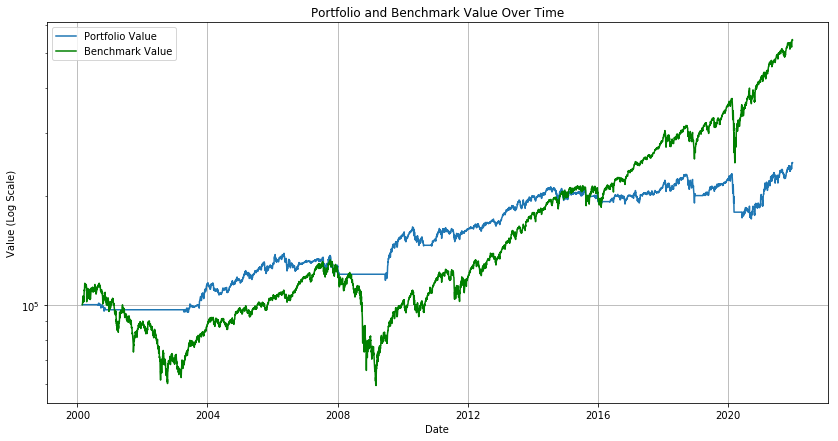

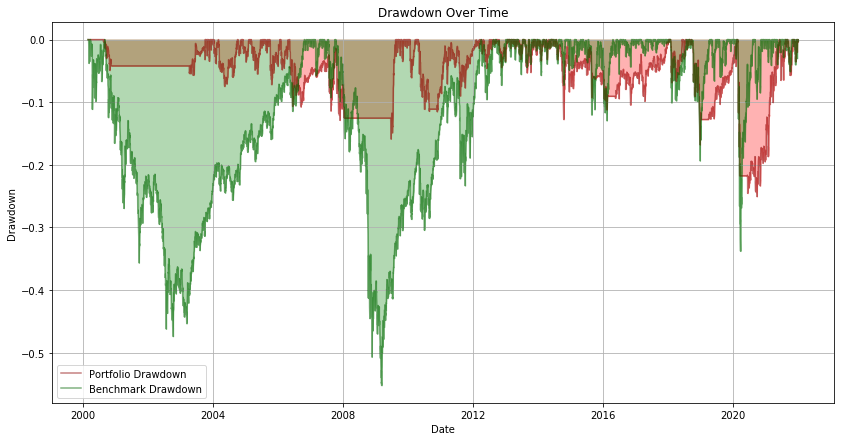

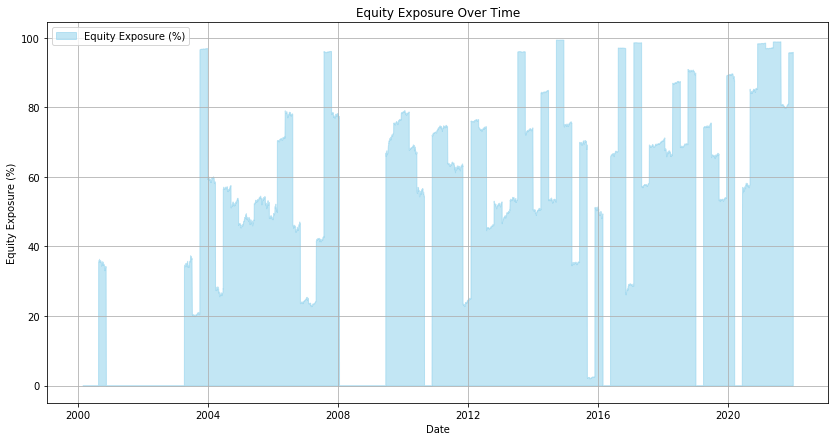

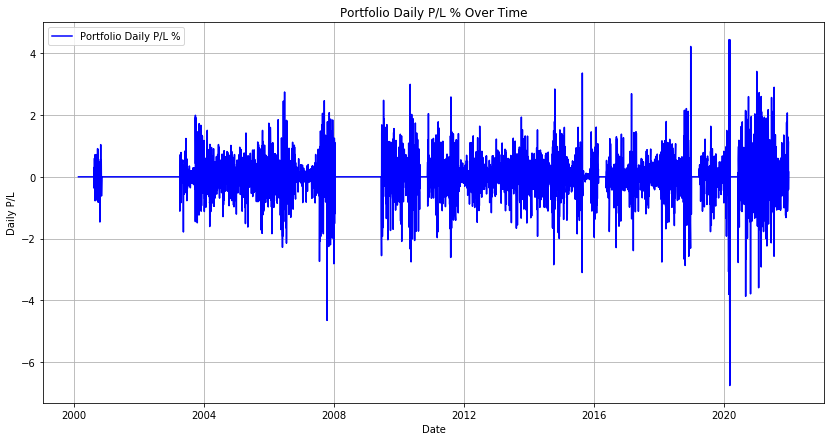

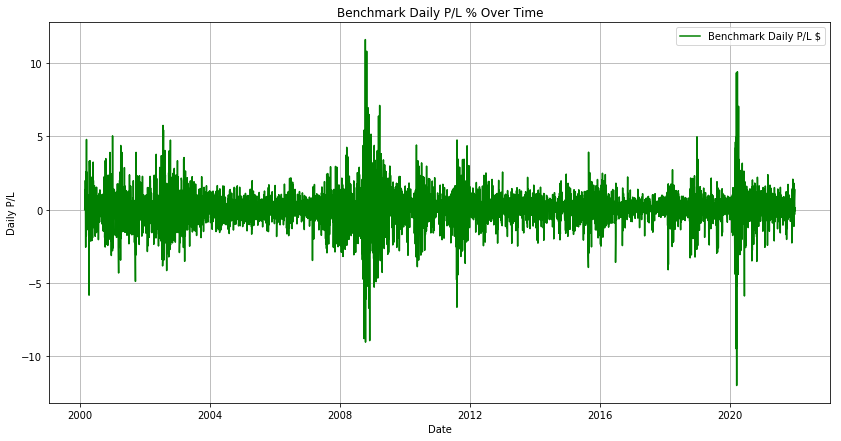

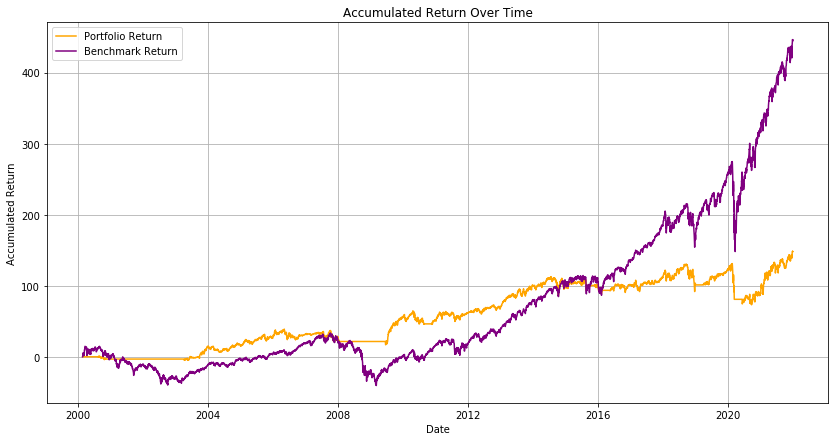

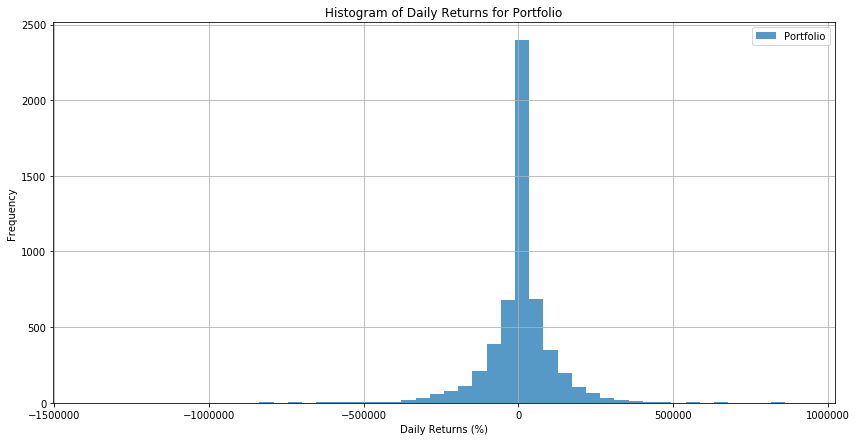

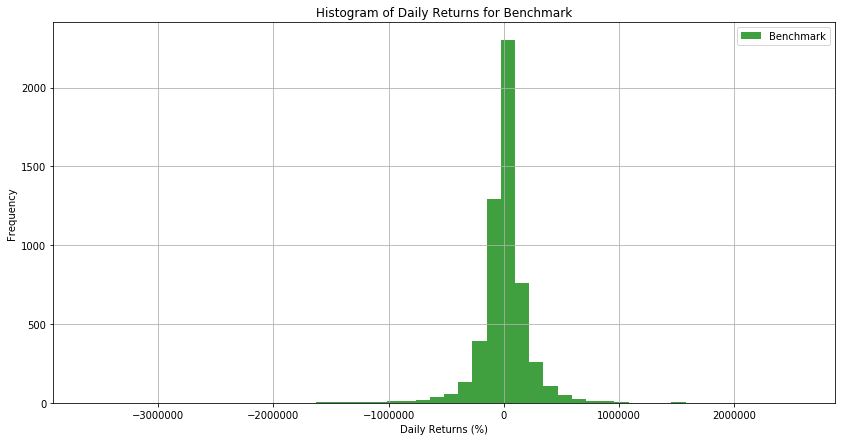

In [17]:
# Time-series Visualizations

# Assuming df_portfolio_data and df_benchmark_data are already loaded as DataFrames
# Make sure that the index (date) column is of datetime type and sorted

# Time Series Chart for Portfolio Value and Benchmark
plt.figure(figsize=(14, 7))
plt.plot(df_portfolio_data['portfolio_value'], label='Portfolio Value')
plt.plot(df_benchmark_data['portfolio_value'], label='Benchmark Value', color='green')
plt.yscale('log')  # Setting the y-axis to a logarithmic scale
plt.title('Portfolio and Benchmark Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value (Log Scale)')
plt.legend()
plt.grid(True)
plt.show()

# Function to calculate drawdown series
def calculate_drawdown_series(df):
    roll_max = df['portfolio_value'].cummax()
    drawdown = df['portfolio_value'] / roll_max - 1.0
    return drawdown

# Calculate Drawdown for Portfolio and Benchmark
df_portfolio_data['drawdown'] = calculate_drawdown_series(df_portfolio_data)
df_benchmark_data['drawdown'] = calculate_drawdown_series(df_benchmark_data)

# Drawdown Chart
plt.figure(figsize=(14, 7))
plt.plot(df_portfolio_data.index, df_portfolio_data['drawdown'], label='Portfolio Drawdown', color='darkred', alpha=0.5)
plt.plot(df_benchmark_data.index, df_benchmark_data['drawdown'], label='Benchmark Drawdown', color='darkgreen', alpha=0.5)
plt.fill_between(df_portfolio_data.index, df_portfolio_data['drawdown'], color='red', alpha=0.3)
plt.fill_between(df_benchmark_data.index, df_benchmark_data['drawdown'], color='green', alpha=0.3)
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# Equity Exposure Over Time (Using 'equity_percent' Column)
plt.figure(figsize=(14, 7))
plt.fill_between(df_portfolio_data.index, df_portfolio_data['equity_percent'], 
                 label='Equity Exposure (%)', alpha=0.5, color='skyblue')
plt.title('Equity Exposure Over Time')
plt.xlabel('Date')
plt.ylabel('Equity Exposure (%)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Daily P/L Chart for Portfolio
plt.figure(figsize=(14, 7))
plt.plot(df_portfolio_data['daily_pl_percent'], label='Portfolio Daily P/L %', color='blue')
plt.title('Portfolio Daily P/L % Over Time')
plt.xlabel('Date')
plt.ylabel('Daily P/L')
plt.legend()
plt.grid(True)
plt.show()

# Daily P/L Chart for Benchmark
plt.figure(figsize=(14, 7))
plt.plot(df_benchmark_data['daily_pl_percent'], label='Benchmark Daily P/L $', color='green')
plt.title('Benchmark Daily P/L % Over Time')
plt.xlabel('Date')
plt.ylabel('Daily P/L')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accumulated P/L
plt.figure(figsize=(14, 7))
plt.plot(df_portfolio_data['accumulated_pl_percent'], label='Portfolio Return', color='orange')
plt.plot(df_benchmark_data['accumulated_pl_percent'], label='Benchmark Return', color='purple')
plt.title('Accumulated Return Over Time')
plt.xlabel('Date')
plt.ylabel('Accumulated Return')
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Daily Returns for Portfolio
plt.figure(figsize=(14, 7))
plt.hist(df_portfolio_data['daily_pl'].dropna() * 100, bins=50, alpha=0.75, label='Portfolio')
plt.title('Histogram of Daily Returns for Portfolio')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Daily Returns for Benchmark
plt.figure(figsize=(14, 7))
plt.hist(df_benchmark_data['daily_pl'].dropna() * 100, bins=50, alpha=0.75, color='green', label='Benchmark')
plt.title('Histogram of Daily Returns for Benchmark')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Extracting Results to .CSV

"""
# Define the base path and model number
base_path = '/Users/siraphobpongkritsagorn/Documents/Leading Assets United/Python Experiment/20240415 Backtrader Sector Stock Momentum/Results'

# Create a directory specific to the model number
model_path = os.path.join(base_path, "model{}".format(model_number))
os.makedirs(model_path, exist_ok=True)

# Extract and format commission and slippage
commission_bp = int(commission_pct * 10000)  # Convert to basis points
slippage_bp = int(slippage_pct * 10000)      # Convert to basis points
# Extract and format start date
start_date_formatted = start_date.strftime('%Y%m%d')  # Format datetime to 'YYYYMMDD'

# Save CSVs to the specified directory
df_portfolio_data.to_csv(os.path.join(model_path, 'portfolio_data_{}_{}_{}_{}.csv'.format(model_number, commission_bp, slippage_bp, start_date_formatted)), index=True)
df_transaction_data.to_csv(os.path.join(model_path, 'transaction_data_{}_{}_{}_{}.csv'.format(model_number, commission_bp, slippage_bp, start_date_formatted)), index=True)
portfolio_summary_table.to_csv(os.path.join(model_path, 'portfolio_performance_summary_{}_{}_{}_{}.csv'.format(model_number, commission_bp, slippage_bp, start_date_formatted)), index=False)
transaction_summary.to_csv(os.path.join(model_path, 'transaction_summary_{}_{}_{}_{}.csv'.format(model_number, commission_bp, slippage_bp, start_date_formatted)), index=False)
benchmark_summary_table.to_csv(os.path.join(model_path, 'benchmark_performance_summary_{}_{}_{}_{}.csv'.format(model_number, commission_bp, slippage_bp, start_date_formatted)), index=False)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-18-3c8ad21026db>, line 22)